In [1]:
import os
import numpy as np
import pandas as pd
import gzip
import requests
import time
from multiprocessing import Pool
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import json
from hashlib import md5
import random

In [2]:
os.chdir('E:/CNSI_project/demo_and_data_3.0/Raw_data/')

In [3]:
def translate_diagnosis(text_data):
    url = "https://google-translate1.p.rapidapi.com/language/translate/v2"
    texts = [text_data]
    
    # Convert the list of texts into the format of "key1=value1&key2=value2&..."
    payload = "&".join(f"q={text}" for text in texts).encode('utf-8')
    headers = {
        "content-type": "application/x-www-form-urlencoded",
        "X-RapidAPI-Key": "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx",   # Change the key to your own.
        "X-RapidAPI-Host": "google-translate1.p.rapidapi.com"
    }

    params = {
        "source": "en",
        "target": "zh-cn"
    }

    response = requests.post(url, data=payload, headers=headers, params=params)

    # Parse the response JSON and extract the translated texts
    response_json = response.json()
    translations = response_json["data"]["translations"]
    translated_texts = [t["translatedText"] for t in translations]
    
    return translated_texts[0]

In [43]:
def translator_baidu(text_data):   
    # Set your own appid/appkey.
    appid = '20231119001885547'
    appkey = 'xxxxxxxxxxxxxxxx'  # Change the key to your own.

    # For list of language codes, please refer to `https://api.fanyi.baidu.com/doc/21`
    from_lang = 'en'
    to_lang =  'zh'

    endpoint = 'http://api.fanyi.baidu.com'
    path = '/api/trans/vip/translate'
    url = endpoint + path

    # query = 'Hello World! This is 1st paragraph.\nThis is 2nd paragraph.\nDirect admission from clinic regarding progressive spastic paraparesis with urinary urgency and bowel incontinency.'
    query = str(text_data)

    # Generate salt and sign
    def make_md5(s, encoding='utf-8'):
        return md5(s.encode(encoding)).hexdigest()

    salt = random.randint(32768, 65536)
    sign = make_md5(appid + query + str(salt) + appkey)

    # Build request
    headers = {'Content-Type': 'application/x-www-form-urlencoded'}
    payload = {'appid': appid, 'q': query, 'from': from_lang, 'to': to_lang, 'salt': salt, 'sign': sign}
    r = requests.post(url, params=payload, headers=headers)
    result = r.json()
    translated_text = result['trans_result'][0]['dst']

    return translated_text

# Explore microbiologyevents.csv.gz files

In [3]:
filename = './mimic-iv-2.2/hosp/microbiologyevents.csv.gz'
with gzip.open(filename, 'rt', encoding='utf-8') as file:
    micro_events = pd.read_csv(file)
micro_events

C:\Users\AaronChen\AppData\Local\Temp\ipykernel_18680\3763963105.py:3: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  micro_events = pd.read_csv(file)


,microevent_id,subject_id,hadm_id,micro_specimen_id,order_provider_id,chartdate,charttime,spec_itemid,spec_type_desc,test_seq,...,org_name,isolate_num,quantity,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation,comments
0,1,10000032,NaN,636109,P28Z0X,2180-03-23 00:00:00,2180-03-23 11:51:00,70093,Blood (Toxo),1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEGATIVE FOR TOXOPLASMA IgG ANTIBODY BY EIA. ...
1,2,10000032,NaN,1836584,P28Z0X,2180-03-23 00:00:00,2180-03-23 11:51:00,70017,SEROLOGY/BLOOD,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POSITIVE BY EIA. A positive IgG result genera...
2,3,10000032,NaN,4131591,P28Z0X,2180-03-23 00:00:00,2180-03-23 11:51:00,70087,Blood (CMV AB),1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,___
3,4,10000032,NaN,4131591,P28Z0X,2180-03-23 00:00:00,2180-03-23 11:51:00,70087,Blood (CMV AB),2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEGATIVE FOR CMV IgM ANTIBODY BY EIA. INTERPR...
4,5,10000032,NaN,6028147,P28Z0X,2180-03-23 00:00:00,2180-03-23 11:51:00,70088,Blood (EBV),1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POSITIVE BY EIA.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228708,3228709,19999987,23865745.0,9008390,NaN,2145-11-05 00:00:00,2145-11-05 10:35:00,70012,BLOOD CULTURE,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.
3228709,3228710,19999987,23865745.0,3162785,NaN,2145-11-05 00:00:00,2145-11-05 12:15:00,70012,BLOOD CULTURE,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.
3228710,3228711,19999987,23865745.0,5530834,NaN,2145-11-06 00:00:00,2145-11-06 13:15:00,70012,BLOOD CULTURE,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.
3228711,3228712,19999987,23865745.0,8701158,NaN,2145-11-06 00:00:00,2145-11-06 17:05:00,70012,BLOOD CULTURE,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.


In [5]:
pd.set_option('display.max_rows',100)
pd.DataFrame(micro_events.spec_type_desc.value_counts(dropna=False))

,spec_type_desc
URINE,1037970
BLOOD CULTURE,646823
SWAB,327805
SPUTUM,162629
STOOL,160465
SEROLOGY/BLOOD,127768
TISSUE,125448
MRSA SCREEN,67007
ABSCESS,51061
BRONCHOALVEOLAR LAVAGE,48836


In [6]:
micro_events['spec_type_desc'].value_counts()

URINE                                                       1037970
BLOOD CULTURE                                                646823
SWAB                                                         327805
SPUTUM                                                       162629
STOOL                                                        160465
SEROLOGY/BLOOD                                               127768
TISSUE                                                       125448
MRSA SCREEN                                                   67007
ABSCESS                                                       51061
BRONCHOALVEOLAR LAVAGE                                        48836
PERITONEAL FLUID                                              44210
IMMUNOLOGY                                                    40122
CSF;SPINAL FLUID                                              34976
PLEURAL FLUID                                                 34756
Staph aureus swab                               

In [4]:
micro_events_csf = micro_events[micro_events['spec_type_desc'].fillna('').str.contains('CSF', case=False)]  # case=False：Case insensitive
micro_events_csf

,microevent_id,subject_id,hadm_id,micro_specimen_id,order_provider_id,chartdate,charttime,spec_itemid,spec_type_desc,test_seq,...,org_name,isolate_num,quantity,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation,comments
398,399,10001217,24597018.0,3955691,NaN,2157-11-19 00:00:00,2157-11-19 02:37:00,70026,CSF;SPINAL FLUID,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...
399,400,10001217,24597018.0,3955691,NaN,2157-11-19 00:00:00,2157-11-19 02:37:00,70026,CSF;SPINAL FLUID,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.
1017,1018,10002557,NaN,3350281,NaN,2147-03-26 00:00:00,2147-03-26 21:05:00,70026,CSF;SPINAL FLUID,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...
1018,1019,10002557,NaN,3350281,NaN,2147-03-26 00:00:00,2147-03-26 21:05:00,70026,CSF;SPINAL FLUID,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.
1060,1061,10002559,NaN,3401726,NaN,2179-06-05 00:00:00,2179-06-05 01:17:00,70026,CSF;SPINAL FLUID,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228631,3228632,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...
3228632,3228633,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.
3228633,3228634,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The sensitivity of an AFB smear on CSF is very...
3228634,3228635,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO FUNGUS ISOLATED.


In [6]:
micro_events_csf[['subject_id','chartdate']].drop_duplicates(keep='first')

,subject_id,chartdate
398,10001217,2157-11-19 00:00:00
1017,10002557,2147-03-26 00:00:00
1060,10002559,2179-06-05 00:00:00
1254,10003019,2174-09-18 00:00:00
2115,10005808,2119-01-02 00:00:00
...,...,...
3227540,19994772,2181-04-18 00:00:00
3227636,19995080,2147-07-13 00:00:00
3228171,19997843,2120-11-18 00:00:00
3228625,19999784,2119-06-22 00:00:00


In [8]:
# Sample Microbial Experiment Results comments
pd.DataFrame(micro_events_csf.comments.value_counts(dropna=False))

,comments
NO GROWTH.,11572
"NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICROORGANISMS SEEN. This is a concentrated smear made by cytospin method, please refer to hematology for a quantitative white blood cell count.",4758
NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICROORGANISMS SEEN.,4484
NO FUNGUS ISOLATED.,2829
___,2073
NO VIRUS ISOLATED.,1675
No Enterovirus isolated.,1126
"The sensitivity of an AFB smear on CSF is very low. If present, AFB may take 3-8 weeks to grow. NO MYCOBACTERIA ISOLATED.",1055
CRYPTOCOCCAL ANTIGEN NOT DETECTED. (Reference Range-Negative). Test performed by Lateral Flow Assay. Results should be evaluated in light of culture results and clinical presentation.,1006
CRYPTOCOCCAL ANTIGEN NOT DETECTED. (Reference Range-Negative). Performed by latex agglutination. Results should be evaluated in light of culture results and clinical presentation.,992


In [12]:
# Microbial type
# Bacteria that need to be manually re-examined for BM
microbes = pd.DataFrame(micro_events_csf.org_name.value_counts(dropna=False))
microbes['En'] = microbes.index
microbes['Ch'] = microbes['En'].apply(translate_diagnosis)
microbes

,org_name,En,Ch
NaN,33889,NaN,楠
"STAPHYLOCOCCUS, COAGULASE NEGATIVE",392,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",葡萄球菌，凝固酶阴性
STAPHYLOCOCCUS EPIDERMIDIS,125,STAPHYLOCOCCUS EPIDERMIDIS,表皮葡萄球菌
STAPH AUREUS COAG +,78,STAPH AUREUS COAG +,金黄色葡萄球菌
ESCHERICHIA COLI,75,ESCHERICHIA COLI,大肠杆菌
CRYPTOCOCCUS NEOFORMANS,45,CRYPTOCOCCUS NEOFORMANS,新型隐球菌
KLEBSIELLA PNEUMONIAE,40,KLEBSIELLA PNEUMONIAE,肺炎克雷伯菌
STREPTOCOCCUS PNEUMONIAE,37,STREPTOCOCCUS PNEUMONIAE,肺炎链球菌
CANCELLED,22,CANCELLED,取消
ENTEROBACTER AEROGENES,19,ENTEROBACTER AEROGENES,产气肠杆菌


In [13]:
microbes.to_csv('./mimic-iv-2.2/hosp/microbes.csv',index=False, encoding="utf_8_sig")

In [9]:
# 0:NBM , 1:BM
def labels(org):
    if pd.isna(org):
        temp = 0
    else:
        temp = 1
    return temp

In [10]:
pd.set_option('display.max_columns',100)
micro_events_csf['culture'] = micro_events_csf['org_name'].apply(labels)
micro_events_csf

C:\Users\AaronChen\AppData\Local\Temp\ipykernel_16332\3561288876.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  micro_events_csf['culture'] = micro_events_csf['org_name'].apply(labels)


,microevent_id,subject_id,hadm_id,micro_specimen_id,order_provider_id,chartdate,charttime,spec_itemid,spec_type_desc,test_seq,storedate,storetime,test_itemid,test_name,org_itemid,org_name,isolate_num,quantity,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation,comments,culture
398,399,10001217,24597018.0,3955691,NaN,2157-11-19 00:00:00,2157-11-19 02:37:00,70026,CSF;SPINAL FLUID,1,2157-11-19 00:00:00,2157-11-19 04:53:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0
399,400,10001217,24597018.0,3955691,NaN,2157-11-19 00:00:00,2157-11-19 02:37:00,70026,CSF;SPINAL FLUID,2,2157-11-22 00:00:00,2157-11-22 11:50:00,90268,FLUID CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.,0
1017,1018,10002557,NaN,3350281,NaN,2147-03-26 00:00:00,2147-03-26 21:05:00,70026,CSF;SPINAL FLUID,1,2147-03-27 00:00:00,2147-03-27 00:48:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0
1018,1019,10002557,NaN,3350281,NaN,2147-03-26 00:00:00,2147-03-26 21:05:00,70026,CSF;SPINAL FLUID,2,2147-03-30 00:00:00,2147-03-30 11:00:00,90268,FLUID CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.,0
1060,1061,10002559,NaN,3401726,NaN,2179-06-05 00:00:00,2179-06-05 01:17:00,70026,CSF;SPINAL FLUID,1,2179-06-05 00:00:00,2179-06-05 04:15:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228631,3228632,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,1,2119-07-07 00:00:00,2119-07-07 18:58:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0
3228632,3228633,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,2,2119-07-10 00:00:00,2119-07-10 11:45:00,90268,FLUID CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.,0
3228633,3228634,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,3,NaN,NaN,90240,ACID FAST CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The sensitivity of an AFB smear on CSF is very...,0
3228634,3228635,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,4,2119-07-28 00:00:00,2119-07-28 15:37:00,90269,FUNGAL CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO FUNGUS ISOLATED.,0


In [11]:
pd.DataFrame(micro_events_csf.culture.value_counts(dropna=False))

,culture
0,33889
1,1087


In [12]:
# Check if there are any cases where org_name (with non-empty content) is different for the same subject_id and the same chartdate, i.e., a person is found to be infected with multiple bacteria on the same day.
# Group the data by subject_id and chartdate, and filter the groups where the org_name are not all the same (ignoring null values)
groups = micro_events_csf.groupby(['subject_id', 'chartdate'])['org_name'].apply(lambda x: x.dropna().nunique()>1)
# Extract the subject_id and chartdate for the groups where the org_name are not all the same
filtered_data = groups[groups].reset_index()[['subject_id','chartdate']]
# Filter the original dataframe to keep only the rows with the extracted subject_id and chartdate values
df_filtered = micro_events_csf.merge(filtered_data, on=['subject_id','chartdate'],how='inner')
df_filtered

,microevent_id,subject_id,hadm_id,micro_specimen_id,order_provider_id,chartdate,charttime,spec_itemid,spec_type_desc,test_seq,storedate,storetime,test_itemid,test_name,org_itemid,org_name,isolate_num,quantity,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation,comments,culture
0,212720,10677030,21221757.0,3738419,NaN,2183-05-12 00:00:00,2183-05-12 08:17:00,70026,CSF;SPINAL FLUID,2,2183-05-18 00:00:00,2183-05-18 12:22:00,90268,FLUID CULTURE,80024.0,STAPHYLOCOCCUS EPIDERMIDIS,1.0,NaN,90012.0,GENTAMICIN,<=0.5,<=,0.50,S,___,1
1,212721,10677030,21221757.0,3738419,NaN,2183-05-12 00:00:00,2183-05-12 08:17:00,70026,CSF;SPINAL FLUID,2,2183-05-18 00:00:00,2183-05-18 12:22:00,90268,FLUID CULTURE,80024.0,STAPHYLOCOCCUS EPIDERMIDIS,1.0,NaN,90015.0,VANCOMYCIN,2,=,2.00,S,___,1
2,212722,10677030,21221757.0,3738419,NaN,2183-05-12 00:00:00,2183-05-12 08:17:00,70026,CSF;SPINAL FLUID,2,2183-05-18 00:00:00,2183-05-18 12:22:00,90268,FLUID CULTURE,80024.0,STAPHYLOCOCCUS EPIDERMIDIS,1.0,NaN,90016.0,OXACILLIN,<=0.25,<=,0.25,S,___,1
3,212723,10677030,21221757.0,3738419,NaN,2183-05-12 00:00:00,2183-05-12 08:17:00,70026,CSF;SPINAL FLUID,2,2183-05-18 00:00:00,2183-05-18 12:22:00,90268,FLUID CULTURE,80024.0,STAPHYLOCOCCUS EPIDERMIDIS,2.0,NaN,90012.0,GENTAMICIN,<=0.5,<=,0.50,S,___,1
4,212724,10677030,21221757.0,3738419,NaN,2183-05-12 00:00:00,2183-05-12 08:17:00,70026,CSF;SPINAL FLUID,2,2183-05-18 00:00:00,2183-05-18 12:22:00,90268,FLUID CULTURE,80024.0,STAPHYLOCOCCUS EPIDERMIDIS,2.0,NaN,90015.0,VANCOMYCIN,2,=,2.00,S,___,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,3225859,19989126,22853928.0,2996032,NaN,2149-08-15 00:00:00,2149-08-15 13:50:00,70026,CSF;SPINAL FLUID,2,2149-08-18 00:00:00,2149-08-18 11:19:00,90268,FLUID CULTURE,80024.0,STAPHYLOCOCCUS EPIDERMIDIS,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
189,3225860,19989126,22853928.0,2996032,NaN,2149-08-15 00:00:00,2149-08-15 13:50:00,70026,CSF;SPINAL FLUID,2,2149-08-18 00:00:00,2149-08-18 11:19:00,90268,FLUID CULTURE,80053.0,ENTEROCOCCUS SP.,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
190,3225861,19989126,22853928.0,2996032,NaN,2149-08-15 00:00:00,2149-08-15 13:50:00,70026,CSF;SPINAL FLUID,2,2149-08-18 00:00:00,2149-08-18 11:19:00,90268,FLUID CULTURE,80085.0,CORYNEBACTERIUM SPECIES (DIPHTHEROIDS),1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
191,3225862,19989126,22853928.0,2996032,NaN,2149-08-15 00:00:00,2149-08-15 13:50:00,70026,CSF;SPINAL FLUID,1,2149-08-15 00:00:00,2149-08-15 16:43:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,___,0


In [13]:
# Look at how many people were found to have multiple bacterial infections on the same day
df_filtered[['subject_id', 'chartdate','org_name']].value_counts(dropna=False).sort_index()

subject_id  chartdate            org_name                              
10677030    2183-05-12 00:00:00  STAPHYLOCOCCUS EPIDERMIDIS                 6
                                 STAPHYLOCOCCUS, COAGULASE NEGATIVE         3
                                 NaN                                        1
11343484    2158-01-13 00:00:00  ENTEROCOCCUS FAECIUM                       3
                                 VIRIDANS STREPTOCOCCI                     10
                                 NaN                                        1
12073331    2171-06-11 00:00:00  ESCHERICHIA COLI                          13
                                 STAPHYLOCOCCUS LUGDUNENSIS                 3
                                 NaN                                        1
13489427    2113-08-20 00:00:00  ENTEROCOCCUS SP.                           2
                                 KOCURIA KRISTINAE                          2
                                 NaN                                  

In [14]:
# See the same patient who had multiple CSF tests on different days
# Group the data by subject_id and chartdate, and filter the groups where the org_name are not all the same (ignoring null values)
groups1 = micro_events_csf.groupby(['subject_id'])['chartdate'].apply(lambda x: x.dropna().nunique()>1)
# Extract the subject_id and chartdate for the groups where the chartdate are not all the same
filtered_data1 = groups1[groups1].reset_index()[['subject_id']]
# # Filter the original dataframe to keep only the rows with the extracted subject_id values
MultiTestSamples = micro_events_csf.merge(filtered_data1, on=['subject_id'],how='inner')
# df_filtered
MultiTestSamples

,microevent_id,subject_id,hadm_id,micro_specimen_id,order_provider_id,chartdate,charttime,spec_itemid,spec_type_desc,test_seq,storedate,storetime,test_itemid,test_name,org_itemid,org_name,isolate_num,quantity,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation,comments,culture
0,9252,10027602,28166872.0,708660,NaN,2201-11-06 00:00:00,2201-11-06 04:46:00,70026,CSF;SPINAL FLUID,1,2201-11-06 00:00:00,2201-11-06 06:51:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0
1,9253,10027602,28166872.0,708660,NaN,2201-11-06 00:00:00,2201-11-06 04:46:00,70026,CSF;SPINAL FLUID,2,2201-11-12 00:00:00,2201-11-12 12:19:00,90268,FLUID CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.,0
2,9254,10027602,28166872.0,708660,NaN,2201-11-06 00:00:00,2201-11-06 04:46:00,70026,CSF;SPINAL FLUID,3,2201-11-28 00:00:00,2201-11-28 10:47:00,90269,FUNGAL CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO FUNGUS ISOLATED.,0
3,9274,10027602,28166872.0,473602,NaN,2201-11-11 00:00:00,2201-11-11 13:35:00,70026,CSF;SPINAL FLUID,1,2201-11-11 00:00:00,2201-11-11 16:59:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0
4,9275,10027602,28166872.0,473602,NaN,2201-11-11 00:00:00,2201-11-11 13:35:00,70026,CSF;SPINAL FLUID,2,2201-11-17 00:00:00,2201-11-17 12:21:00,90268,FLUID CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15192,3228632,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,1,2119-07-07 00:00:00,2119-07-07 18:58:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0
15193,3228633,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,2,2119-07-10 00:00:00,2119-07-10 11:45:00,90268,FLUID CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.,0
15194,3228634,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,3,NaN,NaN,90240,ACID FAST CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The sensitivity of an AFB smear on CSF is very...,0
15195,3228635,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,4,2119-07-28 00:00:00,2119-07-28 15:37:00,90269,FUNGAL CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO FUNGUS ISOLATED.,0


In [15]:
# How many total CSF tests have been done for each patient
MultiTestSamples.subject_id.value_counts(dropna=False)

10230722    173
19622950    140
13624277    124
17749823    103
13951920     89
           ... 
16755391      3
11805460      3
17963251      3
12547294      3
19519745      3
Name: subject_id, Length: 1508, dtype: int64

In [16]:
# The same patient has been tested on different dates with incomplete null results
MultiTestSamples.groupby(['subject_id']).filter(lambda x: x['org_name'].notnull().any())[['subject_id', 'chartdate', 'org_name']].value_counts(dropna=False).sort_index()

subject_id  chartdate            org_name                          
10081883    2165-11-07 00:00:00  STAPHYLOCOCCUS, COAGULASE NEGATIVE    4
                                 NaN                                   1
            2165-11-08 00:00:00  NaN                                   2
10230722    2133-02-19 00:00:00  NaN                                   2
            2133-03-19 00:00:00  NaN                                   2
                                                                      ..
19989126    2149-08-15 00:00:00  STAPHYLOCOCCUS, COAGULASE NEGATIVE    4
                                 NaN                                   4
            2149-08-16 00:00:00  NaN                                   2
            2149-08-21 00:00:00  NaN                                   4
            2149-08-22 00:00:00  NaN                                   3
Length: 1019, dtype: int64

In [17]:
# Check: is the date part of microevent's chartdate and charttime the same, if not then there is a problem with the record. Pick out the differences.
date_time_diff_micro = micro_events_csf[micro_events_csf['chartdate'].str[:10] != micro_events_csf['charttime'].str[:10]]
date_time_diff_micro

,microevent_id,subject_id,hadm_id,micro_specimen_id,order_provider_id,chartdate,charttime,spec_itemid,spec_type_desc,test_seq,storedate,storetime,test_itemid,test_name,org_itemid,org_name,isolate_num,quantity,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation,comments,culture
9294,9295,10027704,NaN,7745590,NaN,2149-04-03 00:00:00,NaN,70026,CSF;SPINAL FLUID,1,2149-04-03 00:00:00,2149-04-03 13:30:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0
9295,9296,10027704,NaN,7745590,NaN,2149-04-03 00:00:00,NaN,70026,CSF;SPINAL FLUID,2,2149-04-06 00:00:00,2149-04-06 13:38:00,90268,FLUID CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.,0
9296,9297,10027704,NaN,7745590,NaN,2149-04-03 00:00:00,NaN,70026,CSF;SPINAL FLUID,3,2149-04-10 00:00:00,2149-04-10 10:52:00,90256,VIRAL CULTURE: R/O HERPES SIMPLEX VIRUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Herpes simplex (HSV) virus isolated.,0
9319,9320,10027808,NaN,6737922,NaN,2150-10-26 00:00:00,NaN,70026,CSF;SPINAL FLUID,1,2150-10-26 00:00:00,2150-10-26 14:17:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0
9320,9321,10027808,NaN,6737922,NaN,2150-10-26 00:00:00,NaN,70026,CSF;SPINAL FLUID,2,2150-10-29 00:00:00,2150-10-29 11:12:00,90268,FLUID CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228631,3228632,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,1,2119-07-07 00:00:00,2119-07-07 18:58:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0
3228632,3228633,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,2,2119-07-10 00:00:00,2119-07-10 11:45:00,90268,FLUID CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.,0
3228633,3228634,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,3,NaN,NaN,90240,ACID FAST CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The sensitivity of an AFB smear on CSF is very...,0
3228634,3228635,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,4,2119-07-28 00:00:00,2119-07-28 15:37:00,90269,FUNGAL CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO FUNGUS ISOLATED.,0


In [18]:
# The screened sample is empty, indicating that the registration is fine and the dates are consistent.
date_time_diff_micro = date_time_diff_micro.dropna(subset=['charttime'])
date_time_diff_micro

,microevent_id,subject_id,hadm_id,micro_specimen_id,order_provider_id,chartdate,charttime,spec_itemid,spec_type_desc,test_seq,storedate,storetime,test_itemid,test_name,org_itemid,org_name,isolate_num,quantity,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation,comments,culture


# Explore labevents.csv.gz file

In [3]:
# Loading labevent data
filename = './mimic-iv-2.2/hosp/labevents.csv.gz'
with gzip.open(filename, 'rt', encoding='utf-8') as file:
    lab_df = pd.read_csv(file)
lab_df

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,1,10000032,NaN,45421181,51237,P28Z0X,2180-03-23 11:51:00,2180-03-23 15:15:00,1.4,1.40,NaN,0.9,1.1,abnormal,ROUTINE,NaN
1,2,10000032,NaN,45421181,51274,P28Z0X,2180-03-23 11:51:00,2180-03-23 15:15:00,___,15.10,sec,9.4,12.5,abnormal,ROUTINE,VERIFIED.
2,3,10000032,NaN,52958335,50853,P28Z0X,2180-03-23 11:51:00,2180-03-25 11:06:00,___,15.00,ng/mL,30.0,60.0,abnormal,ROUTINE,NEW ASSAY IN USE ___: DETECTS D2 AND D3 25-OH ...
3,4,10000032,NaN,52958335,50861,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,102,102.00,IU/L,0.0,40.0,abnormal,ROUTINE,NaN
4,5,10000032,NaN,52958335,50862,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,3.3,3.30,g/dL,3.5,5.2,abnormal,ROUTINE,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118171362,118352501,19999987,23865745.0,85842100,51279,NaN,2145-11-09 05:30:00,2145-11-09 07:06:00,3.52,3.52,m/uL,4.2,5.4,abnormal,ROUTINE,NaN
118171363,118352502,19999987,23865745.0,85842100,51301,NaN,2145-11-09 05:30:00,2145-11-09 07:06:00,5.7,5.70,K/uL,4.0,11.0,NaN,ROUTINE,NaN
118171364,118352503,19999987,NaN,12592768,50912,P09IS0,2146-02-07 11:13:00,2146-02-07 16:26:00,1.1,1.10,mg/dL,0.4,1.1,NaN,ROUTINE,NaN
118171365,118352504,19999987,NaN,12592768,50920,P09IS0,2146-02-07 11:13:00,2146-02-07 16:26:00,NaN,NaN,NaN,NaN,NaN,NaN,ROUTINE,"Using this patient's age, gender, and serum cr..."


In [9]:
lab_df[lab_df['itemid']==50934]

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
704,707,10000084,23052089.0,92482598,50934,NaN,2160-11-20 22:30:00,2160-11-21 00:09:00,303,303.0,NaN,NaN,NaN,NaN,STAT,NaN
764,767,10000084,23052089.0,28549295,50934,NaN,2160-11-21 07:00:00,2160-11-21 10:11:00,4,4.0,NaN,NaN,NaN,NaN,ROUTINE,NaN
790,793,10000084,23052089.0,8583950,50934,NaN,2160-11-22 06:40:00,2160-11-22 08:46:00,4,4.0,NaN,NaN,NaN,NaN,STAT,NaN
824,827,10000084,23052089.0,90000004,50934,NaN,2160-11-23 07:21:00,2160-11-23 09:16:00,12,12.0,NaN,NaN,NaN,NaN,ROUTINE,NaN
848,851,10000084,23052089.0,26999763,50934,NaN,2160-11-24 06:21:00,2160-11-24 08:38:00,4,4.0,NaN,NaN,NaN,NaN,ROUTINE,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118170347,118351483,19999828,25744818.0,66151226,50934,NaN,2149-01-14 05:30:00,2149-01-14 07:44:00,3,3.0,NaN,NaN,NaN,NaN,ROUTINE,NaN
118170381,118351517,19999828,25744818.0,52819383,50934,NaN,2149-01-15 06:20:00,2149-01-15 07:33:00,1,1.0,NaN,NaN,NaN,NaN,ROUTINE,NaN
118170396,118351532,19999828,25744818.0,46809618,50934,NaN,2149-01-16 06:45:00,2149-01-16 08:00:00,7,7.0,NaN,NaN,NaN,NaN,ROUTINE,NaN
118170420,118351556,19999828,25744818.0,68086616,50934,NaN,2149-01-17 06:24:00,2149-01-17 07:31:00,0,0.0,NaN,NaN,NaN,NaN,ROUTINE,NaN


In [20]:
# Statistics lab_df all itemid corresponding to the unit, normally speaking, only one unit representation, if there are a variety of ways to express the unit, the middle with _ connected to form a string, easy to view later
itemid_num = lab_df['itemid'].unique()
itemid_valueuom = []
j = 0
for each in itemid_num:
    temp0 = lab_df[lab_df['itemid']==each]['valueuom'].unique()
    for i in range(len(temp0)):
        if i == 0:
            if temp0[i] is np.nan:
                temp1 = ''
            else:
                temp1 = temp0[i]
        else:
            if temp0[i] is np.nan:
                temp1 += '_'+''
            else:
                temp1 += '_'+temp0[i]
    itemid_valueuom.append(temp1)
    j += 1
    if j%100==0:
        print(f"The current progress is 100/{len(itemid_num)}: {j/len(itemid_num)}")
itemid_valueuom

The current progress is 100/915: 0.1092896174863388
The current progress is 100/915: 0.2185792349726776
The current progress is 100/915: 0.32786885245901637
The current progress is 100/915: 0.4371584699453552
The current progress is 100/915: 0.546448087431694
The current progress is 100/915: 0.6557377049180327
The current progress is 100/915: 0.7650273224043715
The current progress is 100/915: 0.8743169398907104
The current progress is 100/915: 0.9836065573770492


['',
 'sec',
 'ng/mL',
 'IU/L',
 'g/dL',
 'IU/L',
 'ng/mL',
 'mEq/L',
 'IU/L',
 'mEq/L',
 'mg/dL',
 'mg/dL',
 'ng/mL',
 'mEq/L',
 'Ratio',
 'mg/dL',
 'mg/dL',
 'mg/dL',
 'mg/dL',
 '',
 'mg/dL',
 'ng/mL',
 'IU/L',
 '_Pos/Neg',
 '',
 '',
 '',
 '',
 'ug/dL',
 'ug/dL',
 'mg/dL',
 'mg/dL',
 'mEq/L',
 'mEq/L',
 'uIU/mL_uU/ML',
 'ng/dL',
 'mg/dL',
 'mg/dL',
 'mg/dL',
 'mg/dL__EU/dL',
 '',
 'mg/dL',
 'mg/dL',
 '',
 '',
 'units',
 'mg/dL',
 ' ',
 '',
 '',
 'mg/dL',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'mg/dL',
 '%',
 '%',
 '%',
 'g/dL',
 '%',
 'pg',
 '%_g/dL',
 'fL',
 '%',
 '%',
 'K/uL',
 '',
 '%',
 'm/uL',
 'K/uL',
 'mg/dL',
 'sec',
 'IU/L',
 '',
 '',
 'g/dL',
 'IU/L',
 'g/dL',
 '%',
 '%',
 '%',
 '%',
 '%',
 '%',
 '#/uL',
 '#/uL',
 '',
 '',
 'mmol/L',
 '_/hpf',
 '#/hpf',
 '#/hpf',
 '#/hpf',
 '_/hpf',
 '#/hpf',
 '_/hpf',
 '+/-_',
 'mg/dL',
 '%',
 'ug/dL_',
 '',
 'mEq/L',
 'IU/L',
 '',
 '',
 'K/uL_',
 'K/uL_',
 'K/uL_',
 'K/uL_',
 'K/uL_',
 '%',
 'fL_',
 'ug/mL',
 '_U',
 '_U',
 'mg/dL',
 '',

In [21]:
# Matching numeric codes and units
corresponding_unit = pd.DataFrame({"itemid_num":itemid_num,"itemid_valueuom":itemid_valueuom})
corresponding_unit

,itemid_num,itemid_valueuom
0,51237,
1,51274,sec
2,50853,ng/mL
3,50861,IU/L
4,50862,g/dL
...,...,...
910,52313,
911,52066,
912,51826,mg/dL
913,52032,mm Hg


In [22]:
# Check if both subject_id and charttime have null values
print("subject_id of micro_events_csf with null : ",micro_events_csf['subject_id'].isnull().values.any())
print("chartdate of micro_events_csf with null : ", micro_events_csf['chartdate'].isnull().values.any())
print("charttime of micro_events_csf with null : ", micro_events_csf['charttime'].isnull().values.any())
print("subject_id of lab_df with null :", lab_df['subject_id'].isnull().values.any())
print("charttime of lab_df with null :", lab_df['charttime'].isnull().values.any())
print("storetime of lab_df with null :", lab_df['storetime'].isnull().values.any())

subject_id of micro_events_csf with null :  False
chartdate of micro_events_csf with null :  False
charttime of micro_events_csf with null :  True
subject_id of lab_df with null : False
charttime of lab_df with null : False
storetime of lab_df with null : True


In [23]:
# 1, check whether the subject_id of micro_events_csf is included in the subject_id of lab_event
if set(micro_events_csf['subject_id']).issubset(set(lab_df['subject_id'])):
    print("micro_events_csf['subject_id'] 包含于 lab_df['subject_id']")
else:
    print("micro_events_csf['subject_id'] 并没有全包含于 lab_df['subject_id']")

micro_events_csf['subject_id'] 并没有全包含于 lab_df['subject_id']


In [24]:
# 2. Find out what is not included, i.e. it is in the subject_id column of micro_events_csf but not in the subject_id column of lab_df
# Indicates that the person only had microbiological testing done, not biochemical, which is uncommon, but does happen. The biochemical data will be added later, so delete this person's data.
micro_events_csf[~micro_events_csf['subject_id'].isin(lab_df['subject_id'])]

,microevent_id,subject_id,hadm_id,micro_specimen_id,order_provider_id,chartdate,charttime,spec_itemid,spec_type_desc,test_seq,storedate,storetime,test_itemid,test_name,org_itemid,org_name,isolate_num,quantity,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation,comments,culture
489192,489193,11522537,NaN,2765929,NaN,2160-06-25 00:00:00,2160-06-25 19:00:00,70026,CSF;SPINAL FLUID,1,2160-07-03 00:00:00,2160-07-03 11:17:00,90213,Enterovirus Culture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Enterovirus isolated.,0
489193,489194,11522537,NaN,7231906,NaN,2160-06-25 00:00:00,2160-06-25 19:00:00,70026,CSF;SPINAL FLUID,1,2160-06-25 00:00:00,2160-06-25 22:39:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0
489194,489195,11522537,NaN,7231906,NaN,2160-06-25 00:00:00,2160-06-25 19:00:00,70026,CSF;SPINAL FLUID,2,2160-06-29 00:00:00,2160-06-29 12:50:00,90268,FLUID CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.,0


In [25]:
micro_events_csf = micro_events_csf[micro_events_csf['subject_id']!=11522537]
micro_events_csf

,microevent_id,subject_id,hadm_id,micro_specimen_id,order_provider_id,chartdate,charttime,spec_itemid,spec_type_desc,test_seq,storedate,storetime,test_itemid,test_name,org_itemid,org_name,isolate_num,quantity,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation,comments,culture
398,399,10001217,24597018.0,3955691,NaN,2157-11-19 00:00:00,2157-11-19 02:37:00,70026,CSF;SPINAL FLUID,1,2157-11-19 00:00:00,2157-11-19 04:53:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0
399,400,10001217,24597018.0,3955691,NaN,2157-11-19 00:00:00,2157-11-19 02:37:00,70026,CSF;SPINAL FLUID,2,2157-11-22 00:00:00,2157-11-22 11:50:00,90268,FLUID CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.,0
1017,1018,10002557,NaN,3350281,NaN,2147-03-26 00:00:00,2147-03-26 21:05:00,70026,CSF;SPINAL FLUID,1,2147-03-27 00:00:00,2147-03-27 00:48:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0
1018,1019,10002557,NaN,3350281,NaN,2147-03-26 00:00:00,2147-03-26 21:05:00,70026,CSF;SPINAL FLUID,2,2147-03-30 00:00:00,2147-03-30 11:00:00,90268,FLUID CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.,0
1060,1061,10002559,NaN,3401726,NaN,2179-06-05 00:00:00,2179-06-05 01:17:00,70026,CSF;SPINAL FLUID,1,2179-06-05 00:00:00,2179-06-05 04:15:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228631,3228632,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,1,2119-07-07 00:00:00,2119-07-07 18:58:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0
3228632,3228633,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,2,2119-07-10 00:00:00,2119-07-10 11:45:00,90268,FLUID CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.,0
3228633,3228634,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,3,NaN,NaN,90240,ACID FAST CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The sensitivity of an AFB smear on CSF is very...,0
3228634,3228635,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,4,2119-07-28 00:00:00,2119-07-28 15:37:00,90269,FUNGAL CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO FUNGUS ISOLATED.,0


In [26]:
# Running this step takes up 61G of memory, if you don't have enough memory, you can first filter the data in lab_event according to the subject_id of the data in micro_event, and then merge it.
lab_df_csfSubject = lab_df[lab_df['subject_id'].isin(micro_events_csf['subject_id'])]
# Sample labevent by picking out data from microbio's subject_id column, i.e., picking out labevent's CSF test-related data
# Here subject_id and charttime must be the same because a patient cannot have CSF related tests done every time he goes to the hospital.
lab_df_csfSubject['chartdate'] = lab_df_csfSubject['charttime'].str.slice(stop=10)
micro_events_csf1 = micro_events_csf[['subject_id','chartdate']].drop_duplicates(inplace=False)
micro_events_csf1['chartdate'] = micro_events_csf1['chartdate'].str.slice(stop=10)
lab_df1 = lab_df_csfSubject[['subject_id', 'chartdate']].drop_duplicates(inplace=False)
# In the merge to ensure that the two dataframes for the intersection of the two column names are the same, if there is not the same should be modified to the same
# lab_df.rename(columns={'charttime':'chartdate'}, inplace=True)
lab_df_inMicroCSF = pd.merge(micro_events_csf1, lab_df1, on=['subject_id', 'chartdate']).merge(lab_df_csfSubject, on=['subject_id', 'chartdate'], how='left')

lab_df_inMicroCSF

C:\Users\AaronChen\AppData\Local\Temp\ipykernel_16332\3765795774.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lab_df_csfSubject['chartdate'] = lab_df_csfSubject['charttime'].str.slice(stop=10)


,subject_id,chartdate,labevent_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,10001217,2157-11-19,9004,24597018.0,69818655,51790,NaN,2157-11-19 02:37:00,2157-11-19 03:19:00,59,59.00,mg/dL,NaN,NaN,NaN,ROUTINE,NaN
1,10001217,2157-11-19,9005,24597018.0,69818655,51802,NaN,2157-11-19 02:37:00,2157-11-19 03:19:00,42,42.00,mg/dL,15.00,45.00,NaN,ROUTINE,NaN
2,10001217,2157-11-19,9006,24597018.0,74137804,52264,NaN,2157-11-19 02:37:00,2157-11-19 04:55:00,___,100.00,%,NaN,NaN,NaN,ROUTINE,___
3,10001217,2157-11-19,9007,24597018.0,74137804,52272,NaN,2157-11-19 02:37:00,2157-11-19 04:55:00,0,0.00,%,NaN,NaN,NaN,ROUTINE,NaN
4,10001217,2157-11-19,9008,24597018.0,74137804,52281,NaN,2157-11-19 02:37:00,2157-11-19 04:55:00,___,0.00,%,NaN,NaN,NaN,ROUTINE,___
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606312,19999784,2119-07-07,118344739,NaN,42295271,52073,P86PTJ,2119-07-07 17:30:00,2119-07-07 20:12:00,0.03,0.03,K/uL,0.04,0.54,abnormal,ROUTINE,NaN
606313,19999784,2119-07-07,118344740,NaN,42295271,52074,P86PTJ,2119-07-07 17:30:00,2119-07-07 20:12:00,0.33,0.33,K/uL,0.20,0.80,NaN,ROUTINE,NaN
606314,19999784,2119-07-07,118344741,NaN,42295271,52075,P86PTJ,2119-07-07 17:30:00,2119-07-07 20:12:00,3.57,3.57,K/uL,1.60,6.10,NaN,ROUTINE,NaN
606315,19999784,2119-07-07,118344742,NaN,42295271,52135,P86PTJ,2119-07-07 17:30:00,2119-07-07 20:12:00,___,0.20,%,0.00,0.60,NaN,ROUTINE,___


In [27]:
# labevent is the date portion of charttime and storetime the same, if not then the sample experimental data was acquired overnight. Pick out the differences.
# Only some of the filtered out experimental data are meningitis related
chart_store_diff_lab = lab_df_inMicroCSF[lab_df_inMicroCSF['charttime'].str[:10] != lab_df_inMicroCSF['storetime'].str[:10]]
chart_store_diff_lab

,subject_id,chartdate,labevent_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
7,10002557,2147-03-26,33471,NaN,7774520,50933,NaN,2147-03-26 17:00:00,NaN,HOLD. DISCARD GREATER THAN 4 HOURS OLD.,NaN,NaN,NaN,NaN,NaN,STAT,___
8,10002557,2147-03-26,33472,NaN,42155483,50887,NaN,2147-03-26 17:00:00,NaN,HOLD. DISCARD GREATER THAN 24 HRS OLD.,NaN,NaN,NaN,NaN,NaN,STAT,___
9,10002557,2147-03-26,33473,NaN,53288283,50955,NaN,2147-03-26 17:00:00,NaN,___,NaN,NaN,NaN,NaN,NaN,STAT,HOLD.
62,10002559,2179-06-05,34163,NaN,16144394,50955,NaN,2179-06-05 00:00:00,NaN,___,NaN,NaN,NaN,NaN,NaN,STAT,HOLD.
75,10002559,2179-06-05,34176,NaN,33295524,51087,NaN,2179-06-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STAT,RANDOM.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606273,19999784,2119-06-22,118344522,26194817.0,67766582,50900,NaN,2119-06-22 16:55:00,2119-06-23 15:49:00,NaN,NaN,ng/mL,0.0,4.0,NaN,ROUTINE,___
606274,19999784,2119-07-07,118344701,NaN,8750042,52262,NaN,2119-07-07 10:47:00,2119-07-09 21:00:00,DONE,NaN,NaN,NaN,NaN,NaN,ROUTINE,___
606277,19999784,2119-07-07,118344704,NaN,1000025,51796,P86PTJ,2119-07-07 17:18:00,2119-07-08 14:43:00,NaN,NaN,NaN,NaN,NaN,NaN,ROUTINE,___
606278,19999784,2119-07-07,118344705,NaN,1000025,51798,P86PTJ,2119-07-07 17:18:00,2119-07-18 14:07:00,NaN,NaN,NaN,NaN,NaN,NaN,ROUTINE,___


In [28]:
# Remove storetime null, it seems that some of the test results don't come out on the same day
chart_store_diff_lab = chart_store_diff_lab.dropna(subset=['storetime'])
chart_store_diff_lab

,subject_id,chartdate,labevent_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
194,10005808,2119-01-02,75026,26543907.0,37381110,50852,NaN,2119-01-02 14:59:00,2119-01-05 11:23:00,___,5.7,%,4.8,5.9,NaN,ROUTINE,ADA RECOMMENDATIONS:; <7% GOAL OF THERAPY; ...
195,10005808,2119-01-02,75027,26543907.0,37381110,51613,NaN,2119-01-02 14:59:00,2119-01-05 11:23:00,___,117.0,mg/dL,91.0,123.0,NaN,ROUTINE,___
234,10005808,2119-01-02,75066,26543907.0,29400250,50949,NaN,2119-01-02 18:20:00,2119-01-03 20:57:00,386,386.0,mg/dL,70.0,400.0,NaN,ROUTINE,NaN
238,10005808,2119-01-02,75070,26543907.0,29400250,50975,NaN,2119-01-02 18:20:00,2119-01-05 12:58:00,NaN,NaN,NaN,NaN,NaN,NaN,ROUTINE,NO SPECIFIC ABNORMALITIES SEEN;INTERPRETED BY ...
243,10005808,2119-01-02,75075,26543907.0,29400250,51010,NaN,2119-01-02 18:20:00,2119-01-03 20:57:00,410,410.0,pg/mL,240.0,900.0,NaN,ROUTINE,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606273,19999784,2119-06-22,118344522,26194817.0,67766582,50900,NaN,2119-06-22 16:55:00,2119-06-23 15:49:00,NaN,NaN,ng/mL,0.0,4.0,NaN,ROUTINE,___
606274,19999784,2119-07-07,118344701,NaN,8750042,52262,NaN,2119-07-07 10:47:00,2119-07-09 21:00:00,DONE,NaN,NaN,NaN,NaN,NaN,ROUTINE,___
606277,19999784,2119-07-07,118344704,NaN,1000025,51796,P86PTJ,2119-07-07 17:18:00,2119-07-08 14:43:00,NaN,NaN,NaN,NaN,NaN,NaN,ROUTINE,___
606278,19999784,2119-07-07,118344705,NaN,1000025,51798,P86PTJ,2119-07-07 17:18:00,2119-07-18 14:07:00,NaN,NaN,NaN,NaN,NaN,NaN,ROUTINE,___


# Explore the d_labitems.csv file

In [4]:
labitems = pd.read_csv('./mimic-iv-2.2/hosp/d_labitems.csv')
labitems

,itemid,label,fluid,category
0,50801,Alveolar-arterial Gradient,Blood,Blood Gas
1,50802,Base Excess,Blood,Blood Gas
2,50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas
3,50804,Calculated Total CO2,Blood,Blood Gas
4,50805,Carboxyhemoglobin,Blood,Blood Gas
...,...,...,...,...
1617,53150,Anti Hbs,Blood,Chemistry
1618,53151,Anti-la,Blood,Chemistry
1619,53152,HIV FINAL,Blood,Chemistry
1620,53153,HIV Screen,Blood,Chemistry


In [30]:
labitems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1622 entries, 0 to 1621
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   itemid    1622 non-null   int64 
 1   label     1619 non-null   object
 2   fluid     1622 non-null   object
 3   category  1622 non-null   object
dtypes: int64(1), object(3)
memory usage: 50.8+ KB


In [31]:
#Saves the breakdown of each column's data
new_cols = labitems.columns
for each in new_cols:
    df_count = labitems[each].value_counts()
    df_count["空值"] = labitems.shape[0] - df_count.sum()
    path = os.path.join(r"../Processed_data/mimic_labitems", each+r"_breakdown.csv")
    df_count.to_csv(path, encoding='utf-8-sig', index = True)
    
# Upon manual review, the label column was found to have null values, 3 nulls, one space, and a lot of duplicate values. itemid had no null values and no duplicate values.

In [32]:
# # of people who have had a CSF test as a percentage of those at labevent, 3.3% have had a meningitis-related test at one time or another
lab_df_inMicroCSF['subject_id'].unique().shape[0] / lab_df['subject_id'].unique().shape[0]

0.033160593412434144

In [ ]:
# Pick out data related to CSF and blood tests, this step requires translation, slower, about half an hour
labitems_filtered = labitems[labitems['fluid'].str.contains('Blood|Cerebrospinal Fluid', case=False)]
labitems_filtered['label_ch'] = labitems_filtered['label'].apply(translator_baidu)

In [48]:
def value_unit(num):
    if num not in corresponding_unit['itemid_num'].values.tolist():
        unit = ''
    else:
        unit = corresponding_unit[corresponding_unit['itemid_num']==num]['itemid_valueuom'].values[0]
    return unit

In [49]:
labitems_filtered1 = labitems_filtered.copy()
labitems_filtered1['valueuom'] = labitems_filtered1['itemid'].apply(value_unit)
labitems_filtered1

,itemid,label,fluid,category,label_ch,valueuom
0,50801,Alveolar-arterial Gradient,Blood,Blood Gas,肺泡动脉梯度,mm Hg
1,50802,Base Excess,Blood,Blood Gas,基本超额,mEq/L
2,50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas,计算的碳酸氢盐，全血,mEq/L
3,50804,Calculated Total CO2,Blood,Blood Gas,计算的总CO2,mEq/L
4,50805,Carboxyhemoglobin,Blood,Blood Gas,羧基血红蛋白,%
...,...,...,...,...,...,...
1617,53150,Anti Hbs,Blood,Chemistry,抗Hb,
1618,53151,Anti-la,Blood,Chemistry,Anti-la,
1619,53152,HIV FINAL,Blood,Chemistry,HIV最终结果,
1620,53153,HIV Screen,Blood,Chemistry,HIV筛查,


In [50]:
# save
labitems_filtered1.to_csv('./mimic-iv-2.2/hosp/labitems_filtered1_baidu.csv',index=False, encoding="utf_8_sig")

In [52]:
labitems_filtered2 = labitems_filtered1.copy()
labitems_filtered2

,itemid,label,fluid,category,label_ch,valueuom
0,50801,Alveolar-arterial Gradient,Blood,Blood Gas,肺泡动脉梯度,mm Hg
1,50802,Base Excess,Blood,Blood Gas,基本超额,mEq/L
2,50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas,计算的碳酸氢盐，全血,mEq/L
3,50804,Calculated Total CO2,Blood,Blood Gas,计算的总CO2,mEq/L
4,50805,Carboxyhemoglobin,Blood,Blood Gas,羧基血红蛋白,%
...,...,...,...,...,...,...
1617,53150,Anti Hbs,Blood,Chemistry,抗Hb,
1618,53151,Anti-la,Blood,Chemistry,Anti-la,
1619,53152,HIV FINAL,Blood,Chemistry,HIV最终结果,
1620,53153,HIV Screen,Blood,Chemistry,HIV筛查,


In [53]:
# To avoid repetition, string category, fluid, label, itemid and valueuom together, after checking, there is no ‘~’ in these, so you can string them together with ‘~’.
# Null values are transformed into characters as: nan
factors_FullNames = []
labitems_itemid = labitems_filtered2['itemid'].values.tolist()
labitems_label = labitems_filtered2['label'].values.tolist()
labitems_fluid = labitems_filtered2['fluid'].values.tolist()
labitems_category = labitems_filtered2['category'].values.tolist()
labitems_valueuom = labitems_filtered2['valueuom'].values.tolist()
for i in range(len(labitems_filtered2)):
    temp = str(labitems_category[i]) + '~' + str(labitems_fluid[i]) + '~' + str(labitems_label[i]) + '~' + str(labitems_itemid[i]) + '~' + str(labitems_valueuom[i])
    factors_FullNames.append(temp)
labitems_filtered2['factors_FullNames'] = factors_FullNames
labitems_filtered2

,itemid,label,fluid,category,label_ch,valueuom,factors_FullNames
0,50801,Alveolar-arterial Gradient,Blood,Blood Gas,肺泡动脉梯度,mm Hg,Blood Gas~Blood~Alveolar-arterial Gradient~508...
1,50802,Base Excess,Blood,Blood Gas,基本超额,mEq/L,Blood Gas~Blood~Base Excess~50802~mEq/L
2,50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas,计算的碳酸氢盐，全血,mEq/L,"Blood Gas~Blood~Calculated Bicarbonate, Whole ..."
3,50804,Calculated Total CO2,Blood,Blood Gas,计算的总CO2,mEq/L,Blood Gas~Blood~Calculated Total CO2~50804~mEq/L
4,50805,Carboxyhemoglobin,Blood,Blood Gas,羧基血红蛋白,%,Blood Gas~Blood~Carboxyhemoglobin~50805~%
...,...,...,...,...,...,...,...
1617,53150,Anti Hbs,Blood,Chemistry,抗Hb,,Chemistry~Blood~Anti Hbs~53150~
1618,53151,Anti-la,Blood,Chemistry,Anti-la,,Chemistry~Blood~Anti-la~53151~
1619,53152,HIV FINAL,Blood,Chemistry,HIV最终结果,,Chemistry~Blood~HIV FINAL~53152~
1620,53153,HIV Screen,Blood,Chemistry,HIV筛查,,Chemistry~Blood~HIV Screen~53153~


In [54]:
# Pick out the labevent data that's in the CSF and in the factors we've selected.
lab_df_inMicroCSF_aim1 = lab_df_inMicroCSF[lab_df_inMicroCSF["itemid"].isin(labitems_filtered2["itemid"])]
lab_df_inMicroCSF_aim1

,subject_id,chartdate,labevent_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,10001217,2157-11-19,9004,24597018.0,69818655,51790,NaN,2157-11-19 02:37:00,2157-11-19 03:19:00,59,59.00,mg/dL,NaN,NaN,NaN,ROUTINE,NaN
1,10001217,2157-11-19,9005,24597018.0,69818655,51802,NaN,2157-11-19 02:37:00,2157-11-19 03:19:00,42,42.00,mg/dL,15.00,45.00,NaN,ROUTINE,NaN
2,10001217,2157-11-19,9006,24597018.0,74137804,52264,NaN,2157-11-19 02:37:00,2157-11-19 04:55:00,___,100.00,%,NaN,NaN,NaN,ROUTINE,___
3,10001217,2157-11-19,9007,24597018.0,74137804,52272,NaN,2157-11-19 02:37:00,2157-11-19 04:55:00,0,0.00,%,NaN,NaN,NaN,ROUTINE,NaN
4,10001217,2157-11-19,9008,24597018.0,74137804,52281,NaN,2157-11-19 02:37:00,2157-11-19 04:55:00,___,0.00,%,NaN,NaN,NaN,ROUTINE,___
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606312,19999784,2119-07-07,118344739,NaN,42295271,52073,P86PTJ,2119-07-07 17:30:00,2119-07-07 20:12:00,0.03,0.03,K/uL,0.04,0.54,abnormal,ROUTINE,NaN
606313,19999784,2119-07-07,118344740,NaN,42295271,52074,P86PTJ,2119-07-07 17:30:00,2119-07-07 20:12:00,0.33,0.33,K/uL,0.20,0.80,NaN,ROUTINE,NaN
606314,19999784,2119-07-07,118344741,NaN,42295271,52075,P86PTJ,2119-07-07 17:30:00,2119-07-07 20:12:00,3.57,3.57,K/uL,1.60,6.10,NaN,ROUTINE,NaN
606315,19999784,2119-07-07,118344742,NaN,42295271,52135,P86PTJ,2119-07-07 17:30:00,2119-07-07 20:12:00,___,0.20,%,0.00,0.60,NaN,ROUTINE,___


In [55]:
# Our useful lab event detections as a percentage of all lab event detections:
len(lab_df_inMicroCSF_aim1) / len(lab_df_inMicroCSF)

0.8509723461489617

# Creating sample data

In [56]:
# Check: subject_id + charttime to find out if there are duplicates in the row's itemid
non_unique_itemids_subjects = []
lab_df_inMicroCSF_sub = lab_df_inMicroCSF_aim1[['subject_id','chartdate']]
subjectAndcharttime = lab_df_inMicroCSF_sub.drop_duplicates(inplace=False)

In [57]:
# Check: subject_id + charttime to find out if there are duplicates in the row's itemid
for i in range(len(subjectAndcharttime)):
    temp_subject = subjectAndcharttime['subject_id'].iloc[i]
    temp_time = subjectAndcharttime['chartdate'].iloc[i]
    onetime_wetlab = lab_df_inMicroCSF_aim1[(lab_df_inMicroCSF_aim1['subject_id']==temp_subject) & (lab_df_inMicroCSF_aim1['chartdate']==temp_time)]
    # Determine whether the value in column ‘itemid’ is unique or not
    if onetime_wetlab['itemid'].nunique() != len(onetime_wetlab):
        print(f"Itemid, as determined by subject_id {str(temp_subject)} and chartdate {str(temp_time)} in lab_df_inMicroCSF_aim1, is not a unique value !")
        non_unique_itemids_subjects.append([temp_subject, temp_time])

Itemid, as determined by subject_id 10002559 and chartdate 2179-06-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10003019 and chartdate 2174-09-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10005808 and chartdate 2119-01-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10006269 and chartdate 2124-06-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10010430 and chartdate 2158-06-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10014078 and chartdate 2166-08-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10019112 and chartdate 2141-02-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10020187 and chartdate 2169-09-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 10142845 and chartdate 2161-03-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10144359 and chartdate 2147-09-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10144359 and chartdate 2151-01-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10146602 and chartdate 2177-09-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10151766 and chartdate 2129-07-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10152086 and chartdate 2159-06-17 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10152086 and chartdate 2159-06-21 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10152086 and chartdate 2159-06-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 10254097 and chartdate 2138-11-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10255701 and chartdate 2167-09-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10257709 and chartdate 2171-08-17 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10258162 and chartdate 2151-01-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10261509 and chartdate 2117-02-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10262096 and chartdate 2167-03-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10263203 and chartdate 2128-01-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10263247 and chartdate 2146-02-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 10338898 and chartdate 2173-04-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10340105 and chartdate 2151-02-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10342737 and chartdate 2112-05-21 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10342737 and chartdate 2112-06-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10342737 and chartdate 2112-06-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10342737 and chartdate 2112-07-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10342737 and chartdate 2113-01-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10343242 and chartdate 2185-06-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 10473912 and chartdate 2128-09-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10474003 and chartdate 2161-05-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10475473 and chartdate 2132-07-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10476869 and chartdate 2139-01-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10477175 and chartdate 2123-10-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10478422 and chartdate 2136-06-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10483086 and chartdate 2160-04-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10483086 and chartdate 2160-04-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 10575383 and chartdate 2132-05-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10576063 and chartdate 2168-08-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10577827 and chartdate 2191-07-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10578807 and chartdate 2199-06-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10578807 and chartdate 2200-09-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10580201 and chartdate 2138-10-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10580201 and chartdate 2138-10-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10581736 and chartdate 2140-08-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 10697731 and chartdate 2150-02-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10699229 and chartdate 2175-01-21 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10706411 and chartdate 2180-10-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10707704 and chartdate 2115-05-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10709102 and chartdate 2138-08-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10711182 and chartdate 2127-04-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10711182 and chartdate 2134-11-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10723022 and chartdate 2140-10-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 10846520 and chartdate 2140-04-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10856205 and chartdate 2157-04-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10859189 and chartdate 2153-07-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10860466 and chartdate 2165-03-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10860467 and chartdate 2154-04-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10862054 and chartdate 2203-04-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10869856 and chartdate 2147-02-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10874065 and chartdate 2131-11-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 10973518 and chartdate 2145-08-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10973518 and chartdate 2145-11-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10973518 and chartdate 2145-12-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10973518 and chartdate 2146-03-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10973518 and chartdate 2146-05-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10973518 and chartdate 2146-10-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10974948 and chartdate 2159-12-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 10978790 and chartdate 2160-10-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 11092643 and chartdate 2161-04-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11095680 and chartdate 2160-12-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11095916 and chartdate 2166-12-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11097457 and chartdate 2176-10-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11098688 and chartdate 2142-05-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11098767 and chartdate 2128-10-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11101614 and chartdate 2179-07-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11101614 and chartdate 2179-07-17 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 11216635 and chartdate 2127-07-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11216907 and chartdate 2135-11-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11221898 and chartdate 2122-09-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11224611 and chartdate 2174-10-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11224837 and chartdate 2152-09-17 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11237196 and chartdate 2151-08-21 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11240695 and chartdate 2179-05-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11241479 and chartdate 2130-01-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 11330201 and chartdate 2145-09-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11330928 and chartdate 2152-10-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11331130 and chartdate 2128-11-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11335681 and chartdate 2113-04-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11338928 and chartdate 2133-05-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11342626 and chartdate 2155-01-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11343484 and chartdate 2157-12-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11343484 and chartdate 2157-12-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 11463808 and chartdate 2119-08-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11473306 and chartdate 2153-12-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11474021 and chartdate 2168-08-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11474021 and chartdate 2168-08-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11478806 and chartdate 2166-09-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11480554 and chartdate 2183-09-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11482178 and chartdate 2135-09-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11486006 and chartdate 2122-10-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 11590157 and chartdate 2141-12-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11590157 and chartdate 2142-01-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11593376 and chartdate 2144-08-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11595578 and chartdate 2174-09-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11600961 and chartdate 2172-08-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11605271 and chartdate 2113-05-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11608370 and chartdate 2200-10-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11614040 and chartdate 2187-01-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 11690483 and chartdate 2133-12-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11692288 and chartdate 2159-10-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11692288 and chartdate 2161-06-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11694074 and chartdate 2161-10-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11704538 and chartdate 2136-10-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11704987 and chartdate 2133-05-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11708699 and chartdate 2188-09-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11714491 and chartdate 2127-02-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 11834749 and chartdate 2159-06-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11835926 and chartdate 2145-11-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11835929 and chartdate 2169-03-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11835943 and chartdate 2145-03-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11838690 and chartdate 2182-10-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11841078 and chartdate 2175-11-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11841994 and chartdate 2134-11-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11842820 and chartdate 2130-09-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 11939697 and chartdate 2163-05-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11941067 and chartdate 2185-06-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11943473 and chartdate 2130-07-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11945329 and chartdate 2125-05-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11950288 and chartdate 2189-01-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11950288 and chartdate 2189-03-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11954400 and chartdate 2159-11-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 11957494 and chartdate 2127-10-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 12053638 and chartdate 2158-07-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12053638 and chartdate 2163-03-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12053638 and chartdate 2165-06-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12056749 and chartdate 2168-02-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12059275 and chartdate 2133-10-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12061930 and chartdate 2141-10-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12062275 and chartdate 2115-04-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12064625 and chartdate 2188-01-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 12183256 and chartdate 2120-04-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12183689 and chartdate 2114-12-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12183689 and chartdate 2115-01-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12185966 and chartdate 2194-05-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12187047 and chartdate 2169-02-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12187679 and chartdate 2170-10-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12188783 and chartdate 2170-04-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12190999 and chartdate 2169-09-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 12287192 and chartdate 2123-12-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12289074 and chartdate 2159-05-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12294668 and chartdate 2154-11-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12295627 and chartdate 2188-10-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12299020 and chartdate 2172-10-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12303081 and chartdate 2180-05-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12306606 and chartdate 2134-10-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12306690 and chartdate 2143-01-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 12379909 and chartdate 2183-07-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12382161 and chartdate 2167-06-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12384056 and chartdate 2146-12-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12384056 and chartdate 2148-11-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12385889 and chartdate 2115-03-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12388998 and chartdate 2178-01-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12391240 and chartdate 2149-11-17 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12393609 and chartdate 2124-07-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 12505991 and chartdate 2185-01-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12506844 and chartdate 2202-06-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12510466 and chartdate 2182-04-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12510643 and chartdate 2163-11-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12511609 and chartdate 2121-08-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12515451 and chartdate 2116-04-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12515451 and chartdate 2116-06-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12522208 and chartdate 2155-01-21 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 12606779 and chartdate 2170-01-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12617163 and chartdate 2203-05-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12617163 and chartdate 2203-06-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12620516 and chartdate 2128-01-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12632061 and chartdate 2131-01-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12632061 and chartdate 2131-02-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12633112 and chartdate 2128-01-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12640368 and chartdate 2118-04-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 12749902 and chartdate 2117-02-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12749902 and chartdate 2117-02-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12749902 and chartdate 2117-03-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12749902 and chartdate 2117-04-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12751298 and chartdate 2183-05-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12754657 and chartdate 2140-12-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12754657 and chartdate 2142-04-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12755225 and chartdate 2144-06-21 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 12845642 and chartdate 2153-02-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12848344 and chartdate 2191-06-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12850699 and chartdate 2169-06-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12850875 and chartdate 2124-10-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12857528 and chartdate 2173-04-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12860005 and chartdate 2116-10-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12860005 and chartdate 2117-02-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 12860207 and chartdate 2176-01-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 13009403 and chartdate 2181-04-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13010793 and chartdate 2132-10-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13012527 and chartdate 2125-01-25 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13012527 and chartdate 2129-09-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13013201 and chartdate 2141-09-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13013399 and chartdate 2192-11-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13014961 and chartdate 2143-06-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13017215 and chartdate 2161-09-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 13128765 and chartdate 2152-07-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13129523 and chartdate 2135-06-17 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13129657 and chartdate 2177-08-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13129657 and chartdate 2178-01-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13133287 and chartdate 2167-01-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13135946 and chartdate 2143-03-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13136308 and chartdate 2180-05-21 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13136308 and chartdate 2180-08-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 13230528 and chartdate 2136-02-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13238110 and chartdate 2154-07-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13238110 and chartdate 2154-07-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13239192 and chartdate 2132-12-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13239929 and chartdate 2155-06-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13241645 and chartdate 2152-05-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13242005 and chartdate 2156-11-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13245292 and chartdate 2163-02-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 13339704 and chartdate 2136-04-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13343224 and chartdate 2143-07-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13347662 and chartdate 2155-04-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13347919 and chartdate 2175-02-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13352016 and chartdate 2177-01-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13352016 and chartdate 2177-09-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13358528 and chartdate 2177-10-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13360289 and chartdate 2153-09-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 13457624 and chartdate 2123-11-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13465746 and chartdate 2141-11-25 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13469243 and chartdate 2163-01-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13470788 and chartdate 2167-10-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13470788 and chartdate 2167-10-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13478618 and chartdate 2121-02-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13478814 and chartdate 2142-07-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13478814 and chartdate 2142-09-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 13587179 and chartdate 2120-02-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13588636 and chartdate 2141-10-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13588636 and chartdate 2141-10-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13588636 and chartdate 2141-10-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13588636 and chartdate 2141-10-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13588636 and chartdate 2141-10-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13588636 and chartdate 2141-10-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13588636 and chartdate 2141-10-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 13667686 and chartdate 2139-04-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13672784 and chartdate 2119-11-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13672788 and chartdate 2156-03-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13680570 and chartdate 2123-06-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13681703 and chartdate 2173-12-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13687003 and chartdate 2165-04-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13687003 and chartdate 2165-05-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13687003 and chartdate 2165-05-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 13806563 and chartdate 2177-10-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13806563 and chartdate 2177-10-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13808192 and chartdate 2174-04-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13808665 and chartdate 2171-01-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13808665 and chartdate 2176-02-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13813803 and chartdate 2175-01-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13814157 and chartdate 2135-03-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13817910 and chartdate 2141-02-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 13934709 and chartdate 2142-10-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13935426 and chartdate 2156-09-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13935431 and chartdate 2163-04-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13938103 and chartdate 2126-10-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13948093 and chartdate 2167-08-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13950979 and chartdate 2159-03-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13951920 and chartdate 2180-02-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 13951920 and chartdate 2180-02-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 14009583 and chartdate 2152-11-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14012080 and chartdate 2186-03-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14012914 and chartdate 2159-12-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14018555 and chartdate 2189-02-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14018881 and chartdate 2141-12-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14019774 and chartdate 2177-04-21 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14019847 and chartdate 2152-02-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14019847 and chartdate 2152-10-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 14120130 and chartdate 2142-01-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14120635 and chartdate 2149-07-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14120635 and chartdate 2156-09-25 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14124148 and chartdate 2185-11-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14124506 and chartdate 2153-05-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14124506 and chartdate 2153-06-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14129025 and chartdate 2162-06-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14131587 and chartdate 2145-09-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 14216972 and chartdate 2151-02-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14217959 and chartdate 2132-11-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14218331 and chartdate 2147-05-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14220860 and chartdate 2181-09-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14220860 and chartdate 2182-02-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14222637 and chartdate 2158-01-25 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14222643 and chartdate 2193-12-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14222873 and chartdate 2138-12-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 14338363 and chartdate 2162-02-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14339018 and chartdate 2124-08-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14339198 and chartdate 2199-06-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14343405 and chartdate 2142-02-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14344584 and chartdate 2143-11-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14345200 and chartdate 2154-08-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14349680 and chartdate 2186-11-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14350265 and chartdate 2133-05-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 14472165 and chartdate 2121-05-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14473173 and chartdate 2140-07-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14474865 and chartdate 2180-05-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14478580 and chartdate 2152-07-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14479686 and chartdate 2140-03-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14479847 and chartdate 2188-08-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14481555 and chartdate 2153-01-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14481753 and chartdate 2167-12-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 14614500 and chartdate 2145-02-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14615984 and chartdate 2156-09-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14620541 and chartdate 2155-07-25 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14620541 and chartdate 2155-07-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14620541 and chartdate 2155-08-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14620990 and chartdate 2132-05-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14623225 and chartdate 2167-12-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14625711 and chartdate 2122-10-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 14746824 and chartdate 2142-03-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14747289 and chartdate 2176-10-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14747289 and chartdate 2176-11-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14747794 and chartdate 2159-12-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14748508 and chartdate 2131-08-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14751078 and chartdate 2183-12-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14751078 and chartdate 2183-12-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14751543 and chartdate 2200-03-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 14870133 and chartdate 2155-07-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14872501 and chartdate 2148-01-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14872501 and chartdate 2148-01-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14874072 and chartdate 2167-09-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14874195 and chartdate 2125-06-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14876256 and chartdate 2152-07-17 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14879136 and chartdate 2169-10-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 14880219 and chartdate 2204-04-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 15020653 and chartdate 2181-09-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15020653 and chartdate 2188-01-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15020653 and chartdate 2188-01-21 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15022555 and chartdate 2173-09-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15024889 and chartdate 2184-06-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15024914 and chartdate 2163-11-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15024914 and chartdate 2163-11-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15027886 and chartdate 2189-01-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 15124644 and chartdate 2165-10-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15124644 and chartdate 2165-10-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15126168 and chartdate 2144-02-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15127972 and chartdate 2154-12-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15129243 and chartdate 2128-06-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15129243 and chartdate 2128-06-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15134226 and chartdate 2161-11-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15138597 and chartdate 2156-09-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 15228243 and chartdate 2155-02-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15231181 and chartdate 2162-04-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15235658 and chartdate 2128-12-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15235834 and chartdate 2197-09-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15237554 and chartdate 2150-08-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15237603 and chartdate 2153-09-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15245347 and chartdate 2151-02-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15246024 and chartdate 2176-02-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 15378092 and chartdate 2178-05-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15378344 and chartdate 2127-07-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15379488 and chartdate 2147-02-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15381348 and chartdate 2143-01-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15381348 and chartdate 2143-01-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15381348 and chartdate 2143-01-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15382206 and chartdate 2134-06-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15386471 and chartdate 2120-03-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 15525968 and chartdate 2171-01-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15526558 and chartdate 2202-02-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15527821 and chartdate 2131-07-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15529775 and chartdate 2159-05-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15530265 and chartdate 2162-04-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15532044 and chartdate 2136-10-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15533391 and chartdate 2144-03-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15533404 and chartdate 2173-02-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 15638070 and chartdate 2178-11-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15640315 and chartdate 2159-05-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15640944 and chartdate 2119-11-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15644166 and chartdate 2142-07-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15645206 and chartdate 2171-05-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15645206 and chartdate 2171-06-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15647422 and chartdate 2171-07-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15648706 and chartdate 2116-07-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 15732133 and chartdate 2189-01-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15732133 and chartdate 2189-12-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15738181 and chartdate 2156-04-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15742492 and chartdate 2145-01-17 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15743148 and chartdate 2191-05-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15746236 and chartdate 2125-05-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15746236 and chartdate 2125-05-25 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15746236 and chartdate 2125-05-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 15819558 and chartdate 2112-08-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15819558 and chartdate 2112-08-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15819558 and chartdate 2112-09-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15820880 and chartdate 2148-05-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15822576 and chartdate 2131-08-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15829749 and chartdate 2160-12-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15834254 and chartdate 2145-10-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15835407 and chartdate 2156-04-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 15949474 and chartdate 2167-01-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15950873 and chartdate 2134-05-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15950873 and chartdate 2134-06-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15955437 and chartdate 2139-04-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15956147 and chartdate 2112-04-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15957311 and chartdate 2160-11-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15961719 and chartdate 2115-02-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 15970271 and chartdate 2171-12-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 16087181 and chartdate 2176-11-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16088640 and chartdate 2130-08-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16089661 and chartdate 2161-02-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16089740 and chartdate 2168-09-25 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16089740 and chartdate 2168-11-21 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16090720 and chartdate 2142-08-25 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16091889 and chartdate 2184-01-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16093227 and chartdate 2120-12-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 16211382 and chartdate 2169-06-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16211926 and chartdate 2187-03-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16219795 and chartdate 2164-01-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16223492 and chartdate 2163-10-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16223565 and chartdate 2112-12-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16225498 and chartdate 2188-06-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16229016 and chartdate 2123-08-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16229072 and chartdate 2172-10-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 16306965 and chartdate 2139-02-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16306965 and chartdate 2139-07-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16307466 and chartdate 2158-08-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16310874 and chartdate 2163-04-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16312465 and chartdate 2176-04-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16313269 and chartdate 2165-04-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16319633 and chartdate 2187-08-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16323001 and chartdate 2150-01-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 16416367 and chartdate 2170-04-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16416367 and chartdate 2170-05-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16425412 and chartdate 2145-03-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16427358 and chartdate 2121-05-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16427358 and chartdate 2121-05-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16427358 and chartdate 2121-05-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16428118 and chartdate 2136-08-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16429101 and chartdate 2162-03-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 16550115 and chartdate 2126-08-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16550734 and chartdate 2173-10-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16553607 and chartdate 2139-05-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16554963 and chartdate 2146-07-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16554963 and chartdate 2147-06-17 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16557461 and chartdate 2190-06-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16557674 and chartdate 2167-03-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16557766 and chartdate 2179-05-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 16669451 and chartdate 2118-07-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16675350 and chartdate 2162-03-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16678140 and chartdate 2182-01-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16678958 and chartdate 2177-03-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16679469 and chartdate 2125-04-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16679905 and chartdate 2145-08-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16680274 and chartdate 2160-12-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16681305 and chartdate 2152-01-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 16788463 and chartdate 2121-09-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16791613 and chartdate 2150-05-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16793263 and chartdate 2172-01-21 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16795604 and chartdate 2191-02-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16796371 and chartdate 2135-10-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16797123 and chartdate 2189-02-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16797668 and chartdate 2172-06-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16798209 and chartdate 2128-03-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 16888518 and chartdate 2197-07-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16889243 and chartdate 2178-09-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16889934 and chartdate 2191-03-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16889934 and chartdate 2191-07-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16890177 and chartdate 2178-02-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16890177 and chartdate 2178-02-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16891956 and chartdate 2116-02-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16892405 and chartdate 2156-10-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 16981683 and chartdate 2172-04-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16981683 and chartdate 2172-04-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16982710 and chartdate 2173-12-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16987092 and chartdate 2127-08-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16988043 and chartdate 2162-10-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16996620 and chartdate 2122-08-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 16999263 and chartdate 2131-08-21 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17007030 and chartdate 2139-07-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 17084074 and chartdate 2161-04-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17084815 and chartdate 2132-09-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17084815 and chartdate 2132-09-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17084815 and chartdate 2132-09-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17084815 and chartdate 2132-10-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17084815 and chartdate 2132-10-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17084815 and chartdate 2132-10-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17084815 and chartdate 2132-10-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 17173114 and chartdate 2138-08-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17174757 and chartdate 2146-02-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17174757 and chartdate 2146-02-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17176912 and chartdate 2146-07-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17179127 and chartdate 2151-03-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17182960 and chartdate 2126-09-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17183551 and chartdate 2147-11-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17185987 and chartdate 2161-09-17 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 17289837 and chartdate 2149-05-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17290356 and chartdate 2135-05-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17295887 and chartdate 2126-06-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17296711 and chartdate 2196-05-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17307969 and chartdate 2150-12-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17317409 and chartdate 2183-05-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17323720 and chartdate 2179-01-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17324995 and chartdate 2118-11-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 17431089 and chartdate 2117-03-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17431627 and chartdate 2118-05-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17432869 and chartdate 2148-12-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17434024 and chartdate 2142-03-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17437044 and chartdate 2156-08-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17437044 and chartdate 2164-10-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17440353 and chartdate 2154-03-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17440353 and chartdate 2154-04-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 17554818 and chartdate 2164-11-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17554884 and chartdate 2149-10-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17555033 and chartdate 2187-05-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17555214 and chartdate 2188-01-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17556194 and chartdate 2177-10-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17556194 and chartdate 2177-10-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17556194 and chartdate 2177-10-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17556194 and chartdate 2177-10-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 17653099 and chartdate 2178-06-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17655401 and chartdate 2174-02-25 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17655401 and chartdate 2175-11-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17655401 and chartdate 2175-11-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17660467 and chartdate 2154-02-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17661745 and chartdate 2171-07-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17661745 and chartdate 2171-07-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17666626 and chartdate 2159-11-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 17763498 and chartdate 2168-10-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17763728 and chartdate 2124-11-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17768456 and chartdate 2136-01-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17772791 and chartdate 2141-09-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17774636 and chartdate 2183-07-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17776129 and chartdate 2164-11-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17776129 and chartdate 2164-11-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17784929 and chartdate 2179-03-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 17871297 and chartdate 2110-03-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17877075 and chartdate 2173-11-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17880638 and chartdate 2156-02-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17881403 and chartdate 2147-12-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17882272 and chartdate 2126-05-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17885072 and chartdate 2191-05-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17886090 and chartdate 2165-08-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17886566 and chartdate 2130-12-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 17985921 and chartdate 2186-02-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17987969 and chartdate 2185-11-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17989329 and chartdate 2153-10-21 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17992157 and chartdate 2160-04-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17993788 and chartdate 2138-08-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17995655 and chartdate 2153-06-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17996251 and chartdate 2169-09-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 17996251 and chartdate 2169-11-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 18079342 and chartdate 2140-11-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18083807 and chartdate 2176-08-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18084535 and chartdate 2142-10-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18086956 and chartdate 2175-11-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18089838 and chartdate 2115-06-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18094547 and chartdate 2129-11-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18104767 and chartdate 2125-07-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18106633 and chartdate 2162-09-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 18238983 and chartdate 2149-08-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18239927 and chartdate 2190-01-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18242171 and chartdate 2170-05-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18244896 and chartdate 2116-11-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18244896 and chartdate 2116-12-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18246091 and chartdate 2174-11-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18246211 and chartdate 2147-03-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18246211 and chartdate 2149-07-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 18358550 and chartdate 2183-08-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18361380 and chartdate 2174-04-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18362092 and chartdate 2138-05-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18362255 and chartdate 2118-02-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18367177 and chartdate 2174-09-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18367377 and chartdate 2123-04-26 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18369142 and chartdate 2175-01-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18373655 and chartdate 2129-02-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 18508804 and chartdate 2152-11-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18509567 and chartdate 2161-09-21 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18509901 and chartdate 2155-07-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18511257 and chartdate 2119-08-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18512507 and chartdate 2174-06-21 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18512507 and chartdate 2175-01-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18513497 and chartdate 2110-03-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18516988 and chartdate 2144-10-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 18621835 and chartdate 2174-09-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18622276 and chartdate 2143-06-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18622276 and chartdate 2143-06-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18622276 and chartdate 2143-06-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18622276 and chartdate 2143-06-25 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18622276 and chartdate 2143-06-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18624683 and chartdate 2120-10-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18627179 and chartdate 2122-03-02 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 18742611 and chartdate 2136-11-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18743674 and chartdate 2133-10-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18745186 and chartdate 2187-12-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18749421 and chartdate 2166-10-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18751419 and chartdate 2144-03-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18753518 and chartdate 2146-12-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18757959 and chartdate 2153-12-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18758318 and chartdate 2184-08-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 18867933 and chartdate 2190-05-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18870709 and chartdate 2153-09-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18870709 and chartdate 2154-01-17 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18870709 and chartdate 2154-01-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18870709 and chartdate 2154-02-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18871238 and chartdate 2180-12-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18872664 and chartdate 2167-01-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18872814 and chartdate 2130-12-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 18965447 and chartdate 2133-12-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18969321 and chartdate 2192-07-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18970053 and chartdate 2111-08-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18974883 and chartdate 2153-10-20 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18978412 and chartdate 2128-03-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18978412 and chartdate 2128-04-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18981586 and chartdate 2170-07-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 18981645 and chartdate 2178-10-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 19099057 and chartdate 2121-04-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19099057 and chartdate 2121-05-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19099057 and chartdate 2125-06-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19106574 and chartdate 2183-10-05 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19106653 and chartdate 2145-06-21 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19107550 and chartdate 2175-10-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19108098 and chartdate 2126-03-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19111757 and chartdate 2164-12-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 19223384 and chartdate 2123-06-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19223844 and chartdate 2153-01-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19224605 and chartdate 2124-05-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19227226 and chartdate 2185-07-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19227226 and chartdate 2188-10-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19227226 and chartdate 2188-10-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19227226 and chartdate 2189-01-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19231877 and chartdate 2195-07-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 19313943 and chartdate 2164-10-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19317317 and chartdate 2174-09-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19318303 and chartdate 2147-09-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19319088 and chartdate 2133-02-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19319088 and chartdate 2133-04-01 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19319088 and chartdate 2133-04-07 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19319088 and chartdate 2133-06-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19319088 and chartdate 2133-06-17 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 19416768 and chartdate 2136-02-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19417795 and chartdate 2125-06-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19422102 and chartdate 2176-06-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19423334 and chartdate 2152-08-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19423891 and chartdate 2182-12-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19427415 and chartdate 2190-04-06 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19427735 and chartdate 2191-10-17 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19428135 and chartdate 2157-05-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 19545635 and chartdate 2188-07-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19546465 and chartdate 2160-11-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19546918 and chartdate 2131-11-18 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19549869 and chartdate 2156-03-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19552525 and chartdate 2131-07-10 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19553593 and chartdate 2135-11-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19553593 and chartdate 2135-11-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19553593 and chartdate 2135-11-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 19632307 and chartdate 2145-02-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19636818 and chartdate 2200-09-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19641331 and chartdate 2173-11-24 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19641456 and chartdate 2143-02-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19641456 and chartdate 2143-02-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19641456 and chartdate 2143-02-27 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19642300 and chartdate 2156-01-03 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19644375 and chartdate 2124-11-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 19747955 and chartdate 2165-07-04 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19747955 and chartdate 2165-07-09 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19747955 and chartdate 2165-07-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19750498 and chartdate 2118-10-25 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19755253 and chartdate 2147-01-16 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19756052 and chartdate 2153-06-23 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19759059 and chartdate 2175-07-22 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19760462 and chartdate 2135-09-14 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 19853114 and chartdate 2155-10-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19853114 and chartdate 2155-10-17 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19855614 and chartdate 2145-11-12 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19855745 and chartdate 2144-09-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19858647 and chartdate 2161-09-11 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19858968 and chartdate 2119-07-19 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19866517 and chartdate 2154-10-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19867384 and chartdate 2157-06-17 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

Itemid, as determined by subject_id 19982539 and chartdate 2175-05-25 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19982539 and chartdate 2175-05-30 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19984514 and chartdate 2145-03-31 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19985545 and chartdate 2144-08-08 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19986146 and chartdate 2147-08-28 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19986715 and chartdate 2150-11-29 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19989126 and chartdate 2149-08-15 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject_id 19989918 and chartdate 2174-10-13 in lab_df_inMicroCSF_aim1, is not a unique value !
Itemid, as determined by subject

In [58]:
# The last cell run takes 10 minutes, save the results.
with open(r"../Processed_data/mimic/non_unique_itemids_subjects_baidu.pickle", "wb") as f:
    pickle.dump(non_unique_itemids_subjects, f)

In [59]:
non_unique_itemids_subjects = pickle.load(open(r"../Processed_data/mimic/non_unique_itemids_subjects_baidu.pickle", "rb"))
print(len(non_unique_itemids_subjects))
non_unique_itemids_subjects

6026


[[10002559, '2179-06-05'],
 [10003019, '2174-09-18'],
 [10005808, '2119-01-02'],
 [10006269, '2124-06-26'],
 [10010430, '2158-06-08'],
 [10014078, '2166-08-22'],
 [10019112, '2141-02-04'],
 [10020187, '2169-09-01'],
 [10021927, '2175-05-14'],
 [10022041, '2187-05-18'],
 [10027704, '2148-10-23'],
 [10027704, '2149-04-03'],
 [10027808, '2150-10-26'],
 [10027957, '2171-07-04'],
 [10027957, '2172-08-30'],
 [10030549, '2141-11-17'],
 [10030753, '2199-03-20'],
 [10038141, '2170-10-27'],
 [10041408, '2161-12-07'],
 [10043703, '2165-04-04'],
 [10047682, '2142-03-26'],
 [10049746, '2137-01-03'],
 [10049941, '2142-10-26'],
 [10051043, '2197-06-25'],
 [10051043, '2198-06-13'],
 [10053207, '2195-06-25'],
 [10056223, '2121-11-15'],
 [10058033, '2166-03-15'],
 [10059493, '2120-07-02'],
 [10059493, '2120-07-08'],
 [10061102, '2187-11-07'],
 [10066415, '2174-09-09'],
 [10066415, '2174-09-17'],
 [10067086, '2143-09-06'],
 [10073847, '2134-04-30'],
 [10073847, '2134-05-20'],
 [10076526, '2114-02-02'],
 

In [60]:
lab_df_inMicroCSF_aim1

,subject_id,chartdate,labevent_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,10001217,2157-11-19,9004,24597018.0,69818655,51790,NaN,2157-11-19 02:37:00,2157-11-19 03:19:00,59,59.00,mg/dL,NaN,NaN,NaN,ROUTINE,NaN
1,10001217,2157-11-19,9005,24597018.0,69818655,51802,NaN,2157-11-19 02:37:00,2157-11-19 03:19:00,42,42.00,mg/dL,15.00,45.00,NaN,ROUTINE,NaN
2,10001217,2157-11-19,9006,24597018.0,74137804,52264,NaN,2157-11-19 02:37:00,2157-11-19 04:55:00,___,100.00,%,NaN,NaN,NaN,ROUTINE,___
3,10001217,2157-11-19,9007,24597018.0,74137804,52272,NaN,2157-11-19 02:37:00,2157-11-19 04:55:00,0,0.00,%,NaN,NaN,NaN,ROUTINE,NaN
4,10001217,2157-11-19,9008,24597018.0,74137804,52281,NaN,2157-11-19 02:37:00,2157-11-19 04:55:00,___,0.00,%,NaN,NaN,NaN,ROUTINE,___
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606312,19999784,2119-07-07,118344739,NaN,42295271,52073,P86PTJ,2119-07-07 17:30:00,2119-07-07 20:12:00,0.03,0.03,K/uL,0.04,0.54,abnormal,ROUTINE,NaN
606313,19999784,2119-07-07,118344740,NaN,42295271,52074,P86PTJ,2119-07-07 17:30:00,2119-07-07 20:12:00,0.33,0.33,K/uL,0.20,0.80,NaN,ROUTINE,NaN
606314,19999784,2119-07-07,118344741,NaN,42295271,52075,P86PTJ,2119-07-07 17:30:00,2119-07-07 20:12:00,3.57,3.57,K/uL,1.60,6.10,NaN,ROUTINE,NaN
606315,19999784,2119-07-07,118344742,NaN,42295271,52135,P86PTJ,2119-07-07 17:30:00,2119-07-07 20:12:00,___,0.20,%,0.00,0.60,NaN,ROUTINE,___


In [61]:
# Checking the value of itemid for sample 10098215, I found that the two values detected on the same day are very different.
lab_df_inMicroCSF_aim1[(lab_df_inMicroCSF_aim1['subject_id']==10098215) & (lab_df_inMicroCSF_aim1['itemid']==52285)]

,subject_id,chartdate,labevent_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
5175,10098215,2117-02-19,1043242,NaN,37200213,52285,NaN,2117-02-19 15:00:00,2117-02-19 15:27:00,0,0.0,#/uL,0.0,0.0,NaN,STAT,NaN
5212,10098215,2118-02-03,1046977,21701015.0,47710803,52285,NaN,2118-02-03 15:45:00,2118-02-03 17:08:00,93,93.0,#/uL,0.0,0.0,abnormal,ROUTINE,NaN
5218,10098215,2118-02-03,1046983,21701015.0,84412754,52285,NaN,2118-02-03 15:45:00,2118-02-03 17:14:00,130000,130000.0,#/uL,0.0,0.0,abnormal,STAT,NaN


In [62]:
subjectAndcharttime11 = subjectAndcharttime[['subject_id']].drop_duplicates(inplace=False)

1 - (subjectAndcharttime11.shape[0] / subjectAndcharttime.shape[0])  # Proportion of patients who have had a CSF test who have had multiple visits to the hospital for testing

0.2845096551142592

In [66]:
# 方法二，To speed up the code, we can use the pandas library more efficiently by leveraging the merge and groupby functions. 
# This should significantly reduce the computation time. 
subjectAndcharttime1 = subjectAndcharttime11.copy()
# lab_df_inMicroCSF_aim1['charttime'] = lab_df_inMicroCSF_aim1['charttime'].str[:10]
i = 0
for each in factors_FullNames:
    start = time.time()
    factor_itemid = int(each.split('~')[3])

    # Merge subjectAndcharttime1 and lab_df_inMicroCSF_aim1 on the relevant columns`
    merged_df = subjectAndcharttime1[['subject_id']].merge(
        lab_df_inMicroCSF_aim1[lab_df_inMicroCSF_aim1['itemid'] == factor_itemid][['subject_id', 'chartdate', 'valuenum']],
        on=['subject_id'],
        how='left'
    )

    # Group by subject_id and charttime, and concatenate valuenum with '~' separator
    factor_values = (
        merged_df.groupby(['subject_id', 'chartdate'])['valuenum']
        .apply(lambda x: '~'.join(x.dropna().astype(str)))
        .reset_index()
    )

    # Merge the factor_values back into subjectAndcharttime1
    subjectAndcharttime1_each = subjectAndcharttime1[['subject_id']].merge(factor_values, on=['subject_id'], how='left').dropna(axis=0, thresh=2)
    subjectAndcharttime1_each.rename(columns={'valuenum': each}, inplace=True)
    
    if i==0:
        subjectAndcharttime1_merged = subjectAndcharttime1_each
    else:
        subjectAndcharttime1_merged = subjectAndcharttime1_merged.merge(subjectAndcharttime1_each, on=['subject_id','chartdate'], how='outer')
    
    i += 1
    
    end = time.time()
    print(f"The data for columns {each} has been integrated, and it costs {end-start} seconds.")

print(subjectAndcharttime1_merged.shape)
subjectAndcharttime1_merged

The data for columns Blood Gas~Blood~Alveolar-arterial Gradient~50801~mm Hg has been integrated, and it costs 0.05089116096496582 seconds.
The data for columns Blood Gas~Blood~Base Excess~50802~mEq/L has been integrated, and it costs 0.16855263710021973 seconds.
The data for columns Blood Gas~Blood~Calculated Bicarbonate, Whole Blood~50803~mEq/L has been integrated, and it costs 0.03390693664550781 seconds.
The data for columns Blood Gas~Blood~Calculated Total CO2~50804~mEq/L has been integrated, and it costs 0.1655569076538086 seconds.
The data for columns Blood Gas~Blood~Carboxyhemoglobin~50805~% has been integrated, and it costs 0.01695728302001953 seconds.
The data for columns Blood Gas~Blood~Chloride, Whole Blood~50806~mEq/L has been integrated, and it costs 0.042882442474365234 seconds.
The data for columns Blood Gas~Blood~Free Calcium~50808~mmol/L has been integrated, and it costs 0.08677124977111816 seconds.
The data for columns Blood Gas~Blood~Glucose~50809~mg/dL has been inte

The data for columns Chemistry~Blood~Calcium, Total~50893~mg/dL has been integrated, and it costs 0.7041456699371338 seconds.
The data for columns Chemistry~Blood~Calculated Free Testosterone~50894~pg/mL has been integrated, and it costs 0.023923158645629883 seconds.
The data for columns Chemistry~Blood~Calculated TBG~50895~Ratio has been integrated, and it costs 0.02394866943359375 seconds.
The data for columns Chemistry~Blood~Calculated Thyroxine (T4) Index~50896~ug/dL has been integrated, and it costs 0.02393627166748047 seconds.
The data for columns Chemistry~Blood~Call~50897~ has been integrated, and it costs 0.02293848991394043 seconds.
The data for columns Chemistry~Blood~Cancer Antigen 27.29~50898~U/mL has been integrated, and it costs 0.019954442977905273 seconds.
The data for columns Chemistry~Blood~Carbamazepine~50899~ug/mL has been integrated, and it costs 0.026922941207885742 seconds.
The data for columns Chemistry~Blood~Carcinoembyronic Antigen (CEA)~50900~ng/mL has been 

The data for columns Chemistry~Blood~Luteinizing Hormone~50958~mIU/mL has been integrated, and it costs 0.03490757942199707 seconds.
The data for columns Chemistry~Blood~Macro Prolactin~50959~ has been integrated, and it costs 0.031943321228027344 seconds.
The data for columns Chemistry~Blood~Magnesium~50960~mg/dL has been integrated, and it costs 0.7340075969696045 seconds.
The data for columns Chemistry~Blood~Methotrexate~50961~umol/L has been integrated, and it costs 0.03690171241760254 seconds.
The data for columns Chemistry~Blood~N-Acetylprocainamide (NAPA)~50962~ug/mL has been integrated, and it costs 0.03191375732421875 seconds.
The data for columns Chemistry~Blood~NTproBNP~50963~pg/mL has been integrated, and it costs 0.031914710998535156 seconds.
The data for columns Chemistry~Blood~Osmolality, Measured~50964~mOsm/kg has been integrated, and it costs 0.08380722999572754 seconds.
The data for columns Chemistry~Blood~Parathyroid Hormone~50965~pg/mL has been integrated, and it co

The data for columns Hematology~Blood~Bands~51144~% has been integrated, and it costs 0.15760540962219238 seconds.
The data for columns Hematology~Blood~Basophilic Stippling~51145~ has been integrated, and it costs 0.04886937141418457 seconds.
The data for columns Hematology~Blood~Basophils~51146~% has been integrated, and it costs 0.6323094367980957 seconds.
The data for columns Hematology~Blood~Bite Cells~51147~ has been integrated, and it costs 0.047869205474853516 seconds.
The data for columns Hematology~Blood~Blasts~51148~% has been integrated, and it costs 0.04986691474914551 seconds.
The data for columns Hematology~Blood~Bleeding Time~51149~min has been integrated, and it costs 0.04288792610168457 seconds.
The data for columns Hematology~Blood~Blood Parasite Smear~51150~ has been integrated, and it costs 0.05585002899169922 seconds.
The data for columns Hematology~Blood~CD10~51152~ has been integrated, and it costs 0.04687213897705078 seconds.
The data for columns Hematology~Blo

The data for columns Hematology~Blood~H/O Smear~51219~ has been integrated, and it costs 0.05987071990966797 seconds.
The data for columns Hematology~Blood~Heinz Body Prep~51220~ has been integrated, and it costs 0.050863027572631836 seconds.
The data for columns Hematology~Blood~Hematocrit~51221~% has been integrated, and it costs 1.0262587070465088 seconds.
The data for columns Hematology~Blood~Hemoglobin~51222~g/dL has been integrated, and it costs 1.1249587535858154 seconds.
The data for columns Hematology~Blood~Hemoglobin A2~51223~% has been integrated, and it costs 0.054854393005371094 seconds.
The data for columns Hematology~Blood~Hemoglobin C~51224~% has been integrated, and it costs 0.05385470390319824 seconds.
The data for columns Hematology~Blood~Hemoglobin F~51225~% has been integrated, and it costs 0.05385780334472656 seconds.
The data for columns Hematology~Blood~Hemogloblin A~51226~% has been integrated, and it costs 0.05388188362121582 seconds.
The data for columns Hema

The data for columns Hematology~Blood~Sedimentation Rate~51288~mm/hr has been integrated, and it costs 0.1206815242767334 seconds.
The data for columns Hematology~Blood~Serum Viscosity~51289~  has been integrated, and it costs 0.0668191909790039 seconds.
The data for columns Hematology~Blood~Sickle Cell Preparation~51290~ has been integrated, and it costs 0.06582474708557129 seconds.
The data for columns Hematology~Blood~Sickle Cells~51291~ has been integrated, and it costs 0.040884971618652344 seconds.
The data for columns Hematology~Blood~Spherocytes~51292~ has been integrated, and it costs 0.07577371597290039 seconds.
The data for columns Hematology~Blood~Sugar Water Test~51293~ has been integrated, and it costs 0.06682062149047852 seconds.
The data for columns Hematology~Blood~Target Cells~51294~ has been integrated, and it costs 0.04887104034423828 seconds.
The data for columns Hematology~Blood~TdT~51295~ has been integrated, and it costs 0.0668497085571289 seconds.
The data for c

The data for columns Chemistry~Blood~Dr. X~51612~ has been integrated, and it costs 0.06679272651672363 seconds.
The data for columns Chemistry~Blood~eAG~51613~mg/dL_ has been integrated, and it costs 0.06881499290466309 seconds.
The data for columns Chemistry~Blood~Epstein-Barr Virus  EBNA IgG Ab~51614~ has been integrated, and it costs 0.07280683517456055 seconds.
The data for columns Chemistry~Blood~Epstein-Barr Virus EBNA IgG Ab~51615~ has been integrated, and it costs 0.07083940505981445 seconds.
The data for columns Chemistry~Blood~Epstein-Barr Virus IgG Ab Value~51616~ has been integrated, and it costs 0.0718073844909668 seconds.
The data for columns Chemistry~Blood~Epstein-Barr Virus IgM Ab Value~51617~ has been integrated, and it costs 0.07280611991882324 seconds.
The data for columns Chemistry~Blood~Epstein-Barr Virus Interpretation~51618~ has been integrated, and it costs 0.07280445098876953 seconds.
The data for columns Chemistry~Blood~Epstein-Barr Virus VCA IgG Ab~51619~ h

The data for columns Chemistry~Blood~LD, Isoenzyme 3~51682~ has been integrated, and it costs 0.051888227462768555 seconds.
The data for columns Chemistry~Blood~LD, Isoenzyme 4~51683~ has been integrated, and it costs 0.049866676330566406 seconds.
The data for columns Chemistry~Blood~LD, Isoenzyme 5~51684~ has been integrated, and it costs 0.04983997344970703 seconds.
The data for columns Chemistry~Blood~Lidocaine~51685~ has been integrated, and it costs 0.04886937141418457 seconds.
The data for columns Chemistry~Blood~Lip2~51686~ has been integrated, and it costs 0.0498652458190918 seconds.
The data for columns Chemistry~Blood~Lipo Electrophoresis~51687~ has been integrated, and it costs 0.05086398124694824 seconds.
The data for columns Chemistry~Blood~Lyme C6 Ab~51688~ has been integrated, and it costs 0.07482790946960449 seconds.
The data for columns Chemistry~Blood~Lyme G and M Value~51689~ has been integrated, and it costs 0.08377814292907715 seconds.
The data for columns Chemistr

The data for columns Chemistry~Blood~White Blood Cells~51755~K/uL has been integrated, and it costs 0.08075451850891113 seconds.
The data for columns Chemistry~Blood~White Blood Cells~51756~ has been integrated, and it costs 0.08078360557556152 seconds.
The data for columns Chemistry~Blood~Xxx~51757~ has been integrated, and it costs 0.05385613441467285 seconds.
The data for columns Chemistry~Blood~Xylose~51758~ has been integrated, and it costs 0.05388689041137695 seconds.
The data for columns Chemistry~Blood~Z~51759~ has been integrated, and it costs 0.05485248565673828 seconds.
The data for columns Chemistry~Blood~Z~51760~ has been integrated, and it costs 0.05385589599609375 seconds.
The data for columns Chemistry~Blood~Zinc~51761~ has been integrated, and it costs 0.05385923385620117 seconds.
The data for columns Chemistry~Blood~EE1~51762~ has been integrated, and it costs 0.054849863052368164 seconds.
The data for columns Chemistry~Blood~EE2~51763~ has been integrated, and it cos

The data for columns Blood Gas~Blood~Voided Specimen~52036~ has been integrated, and it costs 0.07083988189697266 seconds.
The data for columns Blood Gas~Blood~WB tCO2~52037~ has been integrated, and it costs 0.09471726417541504 seconds.
The data for columns Hematology~Blood~24 Hr~52068~ has been integrated, and it costs 0.06482672691345215 seconds.
The data for columns Hematology~Blood~Absolute Basophil Count~52069~K/uL_ has been integrated, and it costs 0.25830936431884766 seconds.
The data for columns Hematology~Blood~Absolute CD19 Count~52070~ has been integrated, and it costs 0.11170125007629395 seconds.
The data for columns Hematology~Blood~Absolute CD20 Count~52071~ has been integrated, and it costs 0.06482529640197754 seconds.
The data for columns Hematology~Blood~Absolute CD56 Count~52072~ has been integrated, and it costs 0.06582522392272949 seconds.
The data for columns Hematology~Blood~Absolute Eosinophil Count~52073~K/uL_ has been integrated, and it costs 0.258338689804077

The data for columns Hematology~Blood~Immature Granulocytes~52135~% has been integrated, and it costs 0.22639060020446777 seconds.
The data for columns Hematology~Blood~Inhibitor~52136~ has been integrated, and it costs 0.09773945808410645 seconds.
The data for columns Hematology~Blood~Inh Scr~52137~ has been integrated, and it costs 0.06978392601013184 seconds.
The data for columns Hematology~Blood~Kct~52138~ has been integrated, and it costs 0.0698401927947998 seconds.
The data for columns Hematology~Blood~LE Prep~52139~ has been integrated, and it costs 0.07277822494506836 seconds.
The data for columns Hematology~Blood~LS~52140~ has been integrated, and it costs 0.09873485565185547 seconds.
The data for columns Hematology~Blood~Malaria Smear~52141~ has been integrated, and it costs 0.07084155082702637 seconds.
The data for columns Hematology~Blood~Mean Platelet Volume~52142~ has been integrated, and it costs 0.07080960273742676 seconds.
The data for columns Hematology~Blood~Methemal

The data for columns Hematology~Blood~RBCAgg~52203~ has been integrated, and it costs 0.07482671737670898 seconds.
The data for columns Hematology~Blood~RBCDist~52204~ has been integrated, and it costs 0.07480216026306152 seconds.
The data for columns Hematology~Blood~RetScat~52205~ has been integrated, and it costs 0.07377195358276367 seconds.
The data for columns Hematology~Blood~RetFlg~52206~ has been integrated, and it costs 0.0748298168182373 seconds.
The data for columns Hematology~Blood~TurbHbI~52207~ has been integrated, and it costs 0.07480049133300781 seconds.
The data for columns Hematology~Blood~BasoFlg~52208~ has been integrated, and it costs 0.07380270957946777 seconds.
The data for columns Hematology~Blood~EosFlg~52209~ has been integrated, and it costs 0.07380127906799316 seconds.
The data for columns Hematology~Blood~LeftShf~52210~ has been integrated, and it costs 0.07480049133300781 seconds.
The data for columns Hematology~Blood~LymFlg~52211~ has been integrated, and

The data for columns Hematology~Cerebrospinal Fluid~Mesothelial cells #~52269~ has been integrated, and it costs 0.10668563842773438 seconds.
The data for columns Hematology~Cerebrospinal Fluid~Metamyelocytes~52270~% has been integrated, and it costs 0.08876276016235352 seconds.
The data for columns Hematology~Cerebrospinal Fluid~Metas#~52271~ has been integrated, and it costs 0.12865591049194336 seconds.
The data for columns Hematology~Cerebrospinal Fluid~Monocytes~52272~% has been integrated, and it costs 1.2975609302520752 seconds.
The data for columns Hematology~Cerebrospinal Fluid~Monos#~52273~ has been integrated, and it costs 0.10472559928894043 seconds.
The data for columns Hematology~Cerebrospinal Fluid~Myelocytes~52274~% has been integrated, and it costs 0.08473777770996094 seconds.
The data for columns Hematology~Cerebrospinal Fluid~NRBC~52276~% has been integrated, and it costs 0.12566447257995605 seconds.
The data for columns Hematology~Cerebrospinal Fluid~NRBC#~52277~ has

The data for columns Chemistry~Blood~Absolute Neutrophil~53133~ has been integrated, and it costs 0.12765884399414062 seconds.
The data for columns Chemistry~Blood~Absolute Other WBC~53134~ has been integrated, and it costs 0.08377504348754883 seconds.
The data for columns Chemistry~Blood~Acid Phosphatase, Prostatic Fraction~53135~ has been integrated, and it costs 0.08377861976623535 seconds.
The data for columns Chemistry~Blood~Adrenocorticotrophic Hormone~53136~ has been integrated, and it costs 0.08477067947387695 seconds.
The data for columns Chemistry~Blood~Afp Mom~53137~ has been integrated, and it costs 0.08574080467224121 seconds.
The data for columns Chemistry~Blood~(Albumin)~53138~ has been integrated, and it costs 0.08477425575256348 seconds.
The data for columns Chemistry~Blood~Aldosterone~53139~ has been integrated, and it costs 0.0857992172241211 seconds.
The data for columns Chemistry~Blood~Aldosterone~53140~ has been integrated, and it costs 0.08477401733398438 seconds

,subject_id,chartdate,Blood Gas~Blood~Alveolar-arterial Gradient~50801~mm Hg,Blood Gas~Blood~Base Excess~50802~mEq/L,"Blood Gas~Blood~Calculated Bicarbonate, Whole Blood~50803~mEq/L",Blood Gas~Blood~Calculated Total CO2~50804~mEq/L,Blood Gas~Blood~Carboxyhemoglobin~50805~%,"Blood Gas~Blood~Chloride, Whole Blood~50806~mEq/L",Blood Gas~Blood~Free Calcium~50808~mmol/L,Blood Gas~Blood~Glucose~50809~mg/dL,"Blood Gas~Blood~Hematocrit, Calculated~50810~%",Blood Gas~Blood~Hemoglobin~50811~g/dL,Blood Gas~Blood~Intubated~50812~,Blood Gas~Blood~Lactate~50813~mmol/L,Blood Gas~Blood~Methemoglobin~50814~%,Blood Gas~Blood~O2 Flow~50815~L/min,Blood Gas~Blood~Oxygen~50816~%,Blood Gas~Blood~Oxygen Saturation~50817~%,Blood Gas~Blood~pCO2~50818~mm Hg,Blood Gas~Blood~PEEP~50819~,Blood Gas~Blood~pH~50820~units,Blood Gas~Blood~pO2~50821~mm Hg,"Blood Gas~Blood~Potassium, Whole Blood~50822~mEq/L",Blood Gas~Blood~Required O2~50823~,"Blood Gas~Blood~Sodium, Whole Blood~50824~mEq/L",Blood Gas~Blood~Temperature~50825~,Blood Gas~Blood~Tidal Volume~50826~,Blood Gas~Blood~Ventilation Rate~50827~,Blood Gas~Blood~Ventilator~50828~,Chemistry~Blood~% Hemoglobin A1c~50852~%,Chemistry~Blood~25-OH Vitamin D~50853~ng/mL,Chemistry~Blood~Absolute A1c~50854~,Chemistry~Blood~Absolute Hemoglobin~50855~,Chemistry~Blood~Acetaminophen~50856~ug/mL,Chemistry~Blood~Acetone~50857~,Chemistry~Blood~Acid Phosphatase~50858~,"Chemistry~Blood~Acid Phosphatase, Non-Prostatic~50859~","Chemistry~Blood~AFP, Maternal Screen~50860~",Chemistry~Blood~Alanine Aminotransferase (ALT)~50861~IU/L,Chemistry~Blood~Albumin~50862~g/dL,Chemistry~Blood~Alkaline Phosphatase~50863~IU/L,Chemistry~Blood~Alpha-Fetoprotein~50864~ng/mL,Chemistry~Blood~Amikacin~50865~ug/mL,Chemistry~Blood~Ammonia~50866~umol/L,Chemistry~Blood~Amylase~50867~IU/L,Chemistry~Blood~Anion Gap~50868~mEq/L,Chemistry~Blood~Anti-DGP (IgA/IgG)~50869~units,"Chemistry~Blood~Anti-Gliadin Antibody, IgA~50870~units",Chemistry~Blood~Anti-Mitochondrial Antibody~50871~,Chemistry~Blood~Anti-Neutrophil Cytoplasmic Antibody~50872~,...,Hematology~Blood~Factor VII~52844~,Hematology~Blood~Factor VIII~52846~,Hematology~Blood~Factor X~52849~,Hematology~Blood~Factor XI~52851~,Hematology~Blood~Factor XII~52853~,Hematology~Blood~Factor XIII~52855~,Hematology~Blood~Fibrin Degradation Products~52858~,Hematology~Blood~Lupus Anticoagulant~52889~,Hematology~Blood~PT~52921~,Hematology~Blood~PTT~52923~,Hematology~Blood~Reptilase Time~52929~,"Hematology~Blood~Reticulocyte Count, Manual~52934~",Hematology~Blood~Thrombin~52948~,Chemistry~Blood~Alanine Aminotransferase~53084~,Chemistry~Blood~Albumin~53085~,Chemistry~Blood~Alkaline Phosphatase~53086~,Chemistry~Blood~Amylase~53087~,Chemistry~Blood~Asparate Aminotransferase~53088~,"Chemistry~Blood~Bilirubin, Total~53089~",Chemistry~Blood~Gamma Glutamyltranferase~53093~,Chemistry~Blood~HBV VL CT~53094~,Chemistry~Blood~Lyme VsIE/PepC10 Antibody~53095~,"Chemistry~Blood~Protein, Total~53096~",Chemistry~Blood~11-Deoxycorticosterone~53128~,Chemistry~Blood~3t~53129~,Chemistry~Blood~4t~53130~,Chemistry~Blood~5' Nucleotidase~53131~,Chemistry~Blood~Absolute Lymphocyte Count~53132~,Chemistry~Blood~Absolute Neutrophil~53133~,Chemistry~Blood~Absolute Other WBC~53134~,"Chemistry~Blood~Acid Phosphatase, Prostatic Fraction~53135~",Chemistry~Blood~Adrenocorticotrophic Hormone~53136~,Chemistry~Blood~Afp Mom~53137~,Chemistry~Blood~(Albumin)~53138~,Chemistry~Blood~Aldosterone~53139~,Chemistry~Blood~Aldosterone~53140~,Chemistry~Blood~Alpha-1~53141~,Chemistry~Blood~Alpha-1-antitrypsin~53142~,Chemistry~Blood~Alpha-2~53143~,Chemistry~Blood~ANCA Titer~53144~,Chemistry~Blood~Anti-GBM Antibody~53145~,Chemistry~Blood~Anti Hav~53146~,Chemistry~Blood~Anti Hbc~53147~,Chemistry~Blood~Anti Hbe~53148~,Chemistry~Blood~Anti-hbs~53149~,Chemistry~Blood~Anti Hbs~53150~,Chemistry~Blood~Anti-la~53151~,Chemistry~Blood~HIV FINAL~53152~,Chemistry~Blood~HIV Screen~53153~,Chemistry~Blood~Lactate~53154~mmol/L
0,10076526,2114-02-02,592.0,-7.0~-6.0~-8.0~-6.0~-3.0~0.0~0

In [67]:
subjectAndcharttime1_merged = subjectAndcharttime1_merged.sort_values(by=['subject_id','chartdate'], ascending=[True, True], inplace=False)
subjectAndcharttime1_merged

,subject_id,chartdate,Blood Gas~Blood~Alveolar-arterial Gradient~50801~mm Hg,Blood Gas~Blood~Base Excess~50802~mEq/L,"Blood Gas~Blood~Calculated Bicarbonate, Whole Blood~50803~mEq/L",Blood Gas~Blood~Calculated Total CO2~50804~mEq/L,Blood Gas~Blood~Carboxyhemoglobin~50805~%,"Blood Gas~Blood~Chloride, Whole Blood~50806~mEq/L",Blood Gas~Blood~Free Calcium~50808~mmol/L,Blood Gas~Blood~Glucose~50809~mg/dL,"Blood Gas~Blood~Hematocrit, Calculated~50810~%",Blood Gas~Blood~Hemoglobin~50811~g/dL,Blood Gas~Blood~Intubated~50812~,Blood Gas~Blood~Lactate~50813~mmol/L,Blood Gas~Blood~Methemoglobin~50814~%,Blood Gas~Blood~O2 Flow~50815~L/min,Blood Gas~Blood~Oxygen~50816~%,Blood Gas~Blood~Oxygen Saturation~50817~%,Blood Gas~Blood~pCO2~50818~mm Hg,Blood Gas~Blood~PEEP~50819~,Blood Gas~Blood~pH~50820~units,Blood Gas~Blood~pO2~50821~mm Hg,"Blood Gas~Blood~Potassium, Whole Blood~50822~mEq/L",Blood Gas~Blood~Required O2~50823~,"Blood Gas~Blood~Sodium, Whole Blood~50824~mEq/L",Blood Gas~Blood~Temperature~50825~,Blood Gas~Blood~Tidal Volume~50826~,Blood Gas~Blood~Ventilation Rate~50827~,Blood Gas~Blood~Ventilator~50828~,Chemistry~Blood~% Hemoglobin A1c~50852~%,Chemistry~Blood~25-OH Vitamin D~50853~ng/mL,Chemistry~Blood~Absolute A1c~50854~,Chemistry~Blood~Absolute Hemoglobin~50855~,Chemistry~Blood~Acetaminophen~50856~ug/mL,Chemistry~Blood~Acetone~50857~,Chemistry~Blood~Acid Phosphatase~50858~,"Chemistry~Blood~Acid Phosphatase, Non-Prostatic~50859~","Chemistry~Blood~AFP, Maternal Screen~50860~",Chemistry~Blood~Alanine Aminotransferase (ALT)~50861~IU/L,Chemistry~Blood~Albumin~50862~g/dL,Chemistry~Blood~Alkaline Phosphatase~50863~IU/L,Chemistry~Blood~Alpha-Fetoprotein~50864~ng/mL,Chemistry~Blood~Amikacin~50865~ug/mL,Chemistry~Blood~Ammonia~50866~umol/L,Chemistry~Blood~Amylase~50867~IU/L,Chemistry~Blood~Anion Gap~50868~mEq/L,Chemistry~Blood~Anti-DGP (IgA/IgG)~50869~units,"Chemistry~Blood~Anti-Gliadin Antibody, IgA~50870~units",Chemistry~Blood~Anti-Mitochondrial Antibody~50871~,Chemistry~Blood~Anti-Neutrophil Cytoplasmic Antibody~50872~,...,Hematology~Blood~Factor VII~52844~,Hematology~Blood~Factor VIII~52846~,Hematology~Blood~Factor X~52849~,Hematology~Blood~Factor XI~52851~,Hematology~Blood~Factor XII~52853~,Hematology~Blood~Factor XIII~52855~,Hematology~Blood~Fibrin Degradation Products~52858~,Hematology~Blood~Lupus Anticoagulant~52889~,Hematology~Blood~PT~52921~,Hematology~Blood~PTT~52923~,Hematology~Blood~Reptilase Time~52929~,"Hematology~Blood~Reticulocyte Count, Manual~52934~",Hematology~Blood~Thrombin~52948~,Chemistry~Blood~Alanine Aminotransferase~53084~,Chemistry~Blood~Albumin~53085~,Chemistry~Blood~Alkaline Phosphatase~53086~,Chemistry~Blood~Amylase~53087~,Chemistry~Blood~Asparate Aminotransferase~53088~,"Chemistry~Blood~Bilirubin, Total~53089~",Chemistry~Blood~Gamma Glutamyltranferase~53093~,Chemistry~Blood~HBV VL CT~53094~,Chemistry~Blood~Lyme VsIE/PepC10 Antibody~53095~,"Chemistry~Blood~Protein, Total~53096~",Chemistry~Blood~11-Deoxycorticosterone~53128~,Chemistry~Blood~3t~53129~,Chemistry~Blood~4t~53130~,Chemistry~Blood~5' Nucleotidase~53131~,Chemistry~Blood~Absolute Lymphocyte Count~53132~,Chemistry~Blood~Absolute Neutrophil~53133~,Chemistry~Blood~Absolute Other WBC~53134~,"Chemistry~Blood~Acid Phosphatase, Prostatic Fraction~53135~",Chemistry~Blood~Adrenocorticotrophic Hormone~53136~,Chemistry~Blood~Afp Mom~53137~,Chemistry~Blood~(Albumin)~53138~,Chemistry~Blood~Aldosterone~53139~,Chemistry~Blood~Aldosterone~53140~,Chemistry~Blood~Alpha-1~53141~,Chemistry~Blood~Alpha-1-antitrypsin~53142~,Chemistry~Blood~Alpha-2~53143~,Chemistry~Blood~ANCA Titer~53144~,Chemistry~Blood~Anti-GBM Antibody~53145~,Chemistry~Blood~Anti Hav~53146~,Chemistry~Blood~Anti Hbc~53147~,Chemistry~Blood~Anti Hbe~53148~,Chemistry~Blood~Anti-hbs~53149~,Chemistry~Blood~Anti Hbs~53150~,Chemistry~Blood~Anti-la~53151~,Chemistry~Blood~HIV FINAL~53152~,Chemistry~Blood~HIV Screen~53153~,Chemistry~Blood~Lactate~53154~mmol/L
10328,10001217,2157-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [68]:
subjectAndcharttime1_merged.to_csv("subjectAndcharttime1_baidu.csv",index=None)

# Add age, gender parameters

In [69]:
patients = pd.read_csv('./mimic-iv-2.2/hosp/patients.csv')
patients

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN
...,...,...,...,...,...,...
299707,19999828,F,46,2147,2017 - 2019,NaN
299708,19999829,F,28,2186,2008 - 2010,NaN
299709,19999840,M,58,2164,2008 - 2010,2164-09-17
299710,19999914,F,49,2158,2017 - 2019,NaN


In [70]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299712 entries, 0 to 299711
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   subject_id         299712 non-null  int64 
 1   gender             299712 non-null  object
 2   anchor_age         299712 non-null  int64 
 3   anchor_year        299712 non-null  int64 
 4   anchor_year_group  299712 non-null  object
 5   dod                29076 non-null   object
dtypes: int64(3), object(3)
memory usage: 13.7+ MB


In [71]:
patients1 = patients.copy()
patients1['birthyear'] = patients1['anchor_year'] - patients1['anchor_age']
patients1

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,birthyear
0,10000032,F,52,2180,2014 - 2016,2180-09-09,2128
1,10000048,F,23,2126,2008 - 2010,NaN,2103
2,10000068,F,19,2160,2008 - 2010,NaN,2141
3,10000084,M,72,2160,2017 - 2019,2161-02-13,2088
4,10000102,F,27,2136,2008 - 2010,NaN,2109
...,...,...,...,...,...,...,...
299707,19999828,F,46,2147,2017 - 2019,NaN,2101
299708,19999829,F,28,2186,2008 - 2010,NaN,2158
299709,19999840,M,58,2164,2008 - 2010,2164-09-17,2106
299710,19999914,F,49,2158,2017 - 2019,NaN,2109


In [72]:
# Checks if subject_id in subjectAndcharttime1_merged is present that is not present in patients1. The result proves that they all exist.
subjectAndcharttime1_merged[~subjectAndcharttime1_merged['subject_id'].isin(patients1['subject_id'])]

,subject_id,chartdate,Blood Gas~Blood~Alveolar-arterial Gradient~50801~mm Hg,Blood Gas~Blood~Base Excess~50802~mEq/L,"Blood Gas~Blood~Calculated Bicarbonate, Whole Blood~50803~mEq/L",Blood Gas~Blood~Calculated Total CO2~50804~mEq/L,Blood Gas~Blood~Carboxyhemoglobin~50805~%,"Blood Gas~Blood~Chloride, Whole Blood~50806~mEq/L",Blood Gas~Blood~Free Calcium~50808~mmol/L,Blood Gas~Blood~Glucose~50809~mg/dL,"Blood Gas~Blood~Hematocrit, Calculated~50810~%",Blood Gas~Blood~Hemoglobin~50811~g/dL,Blood Gas~Blood~Intubated~50812~,Blood Gas~Blood~Lactate~50813~mmol/L,Blood Gas~Blood~Methemoglobin~50814~%,Blood Gas~Blood~O2 Flow~50815~L/min,Blood Gas~Blood~Oxygen~50816~%,Blood Gas~Blood~Oxygen Saturation~50817~%,Blood Gas~Blood~pCO2~50818~mm Hg,Blood Gas~Blood~PEEP~50819~,Blood Gas~Blood~pH~50820~units,Blood Gas~Blood~pO2~50821~mm Hg,"Blood Gas~Blood~Potassium, Whole Blood~50822~mEq/L",Blood Gas~Blood~Required O2~50823~,"Blood Gas~Blood~Sodium, Whole Blood~50824~mEq/L",Blood Gas~Blood~Temperature~50825~,Blood Gas~Blood~Tidal Volume~50826~,Blood Gas~Blood~Ventilation Rate~50827~,Blood Gas~Blood~Ventilator~50828~,Chemistry~Blood~% Hemoglobin A1c~50852~%,Chemistry~Blood~25-OH Vitamin D~50853~ng/mL,Chemistry~Blood~Absolute A1c~50854~,Chemistry~Blood~Absolute Hemoglobin~50855~,Chemistry~Blood~Acetaminophen~50856~ug/mL,Chemistry~Blood~Acetone~50857~,Chemistry~Blood~Acid Phosphatase~50858~,"Chemistry~Blood~Acid Phosphatase, Non-Prostatic~50859~","Chemistry~Blood~AFP, Maternal Screen~50860~",Chemistry~Blood~Alanine Aminotransferase (ALT)~50861~IU/L,Chemistry~Blood~Albumin~50862~g/dL,Chemistry~Blood~Alkaline Phosphatase~50863~IU/L,Chemistry~Blood~Alpha-Fetoprotein~50864~ng/mL,Chemistry~Blood~Amikacin~50865~ug/mL,Chemistry~Blood~Ammonia~50866~umol/L,Chemistry~Blood~Amylase~50867~IU/L,Chemistry~Blood~Anion Gap~50868~mEq/L,Chemistry~Blood~Anti-DGP (IgA/IgG)~50869~units,"Chemistry~Blood~Anti-Gliadin Antibody, IgA~50870~units",Chemistry~Blood~Anti-Mitochondrial Antibody~50871~,Chemistry~Blood~Anti-Neutrophil Cytoplasmic Antibody~50872~,...,Hematology~Blood~Factor VII~52844~,Hematology~Blood~Factor VIII~52846~,Hematology~Blood~Factor X~52849~,Hematology~Blood~Factor XI~52851~,Hematology~Blood~Factor XII~52853~,Hematology~Blood~Factor XIII~52855~,Hematology~Blood~Fibrin Degradation Products~52858~,Hematology~Blood~Lupus Anticoagulant~52889~,Hematology~Blood~PT~52921~,Hematology~Blood~PTT~52923~,Hematology~Blood~Reptilase Time~52929~,"Hematology~Blood~Reticulocyte Count, Manual~52934~",Hematology~Blood~Thrombin~52948~,Chemistry~Blood~Alanine Aminotransferase~53084~,Chemistry~Blood~Albumin~53085~,Chemistry~Blood~Alkaline Phosphatase~53086~,Chemistry~Blood~Amylase~53087~,Chemistry~Blood~Asparate Aminotransferase~53088~,"Chemistry~Blood~Bilirubin, Total~53089~",Chemistry~Blood~Gamma Glutamyltranferase~53093~,Chemistry~Blood~HBV VL CT~53094~,Chemistry~Blood~Lyme VsIE/PepC10 Antibody~53095~,"Chemistry~Blood~Protein, Total~53096~",Chemistry~Blood~11-Deoxycorticosterone~53128~,Chemistry~Blood~3t~53129~,Chemistry~Blood~4t~53130~,Chemistry~Blood~5' Nucleotidase~53131~,Chemistry~Blood~Absolute Lymphocyte Count~53132~,Chemistry~Blood~Absolute Neutrophil~53133~,Chemistry~Blood~Absolute Other WBC~53134~,"Chemistry~Blood~Acid Phosphatase, Prostatic Fraction~53135~",Chemistry~Blood~Adrenocorticotrophic Hormone~53136~,Chemistry~Blood~Afp Mom~53137~,Chemistry~Blood~(Albumin)~53138~,Chemistry~Blood~Aldosterone~53139~,Chemistry~Blood~Aldosterone~53140~,Chemistry~Blood~Alpha-1~53141~,Chemistry~Blood~Alpha-1-antitrypsin~53142~,Chemistry~Blood~Alpha-2~53143~,Chemistry~Blood~ANCA Titer~53144~,Chemistry~Blood~Anti-GBM Antibody~53145~,Chemistry~Blood~Anti Hav~53146~,Chemistry~Blood~Anti Hbc~53147~,Chemistry~Blood~Anti Hbe~53148~,Chemistry~Blood~Anti-hbs~53149~,Chemistry~Blood~Anti Hbs~53150~,Chemistry~Blood~Anti-la~53151~,Chemistry~Blood~HIV FINAL~53152~,Chemistry~Blood~HIV Screen~53153~,Chemistry~Blood~Lactate~53154~mmol/L


In [73]:
subjectAndcharttime7 = subjectAndcharttime1_merged.copy()
subjectAndcharttime7['gender'] = subjectAndcharttime7['subject_id'].apply(lambda x: patients1.loc[x==patients1['subject_id'], 'gender'].iloc[0])
subjectAndcharttime7['birthyear'] = subjectAndcharttime7['subject_id'].apply(lambda x: patients1.loc[x==patients1['subject_id'], 'birthyear'].iloc[0])
subjectAndcharttime7['chartdate_int'] = subjectAndcharttime7['chartdate'].str[:4].astype(int)
subjectAndcharttime7['age'] = subjectAndcharttime7['chartdate_int'] - subjectAndcharttime7['birthyear']
subjectAndcharttime7

,subject_id,chartdate,Blood Gas~Blood~Alveolar-arterial Gradient~50801~mm Hg,Blood Gas~Blood~Base Excess~50802~mEq/L,"Blood Gas~Blood~Calculated Bicarbonate, Whole Blood~50803~mEq/L",Blood Gas~Blood~Calculated Total CO2~50804~mEq/L,Blood Gas~Blood~Carboxyhemoglobin~50805~%,"Blood Gas~Blood~Chloride, Whole Blood~50806~mEq/L",Blood Gas~Blood~Free Calcium~50808~mmol/L,Blood Gas~Blood~Glucose~50809~mg/dL,"Blood Gas~Blood~Hematocrit, Calculated~50810~%",Blood Gas~Blood~Hemoglobin~50811~g/dL,Blood Gas~Blood~Intubated~50812~,Blood Gas~Blood~Lactate~50813~mmol/L,Blood Gas~Blood~Methemoglobin~50814~%,Blood Gas~Blood~O2 Flow~50815~L/min,Blood Gas~Blood~Oxygen~50816~%,Blood Gas~Blood~Oxygen Saturation~50817~%,Blood Gas~Blood~pCO2~50818~mm Hg,Blood Gas~Blood~PEEP~50819~,Blood Gas~Blood~pH~50820~units,Blood Gas~Blood~pO2~50821~mm Hg,"Blood Gas~Blood~Potassium, Whole Blood~50822~mEq/L",Blood Gas~Blood~Required O2~50823~,"Blood Gas~Blood~Sodium, Whole Blood~50824~mEq/L",Blood Gas~Blood~Temperature~50825~,Blood Gas~Blood~Tidal Volume~50826~,Blood Gas~Blood~Ventilation Rate~50827~,Blood Gas~Blood~Ventilator~50828~,Chemistry~Blood~% Hemoglobin A1c~50852~%,Chemistry~Blood~25-OH Vitamin D~50853~ng/mL,Chemistry~Blood~Absolute A1c~50854~,Chemistry~Blood~Absolute Hemoglobin~50855~,Chemistry~Blood~Acetaminophen~50856~ug/mL,Chemistry~Blood~Acetone~50857~,Chemistry~Blood~Acid Phosphatase~50858~,"Chemistry~Blood~Acid Phosphatase, Non-Prostatic~50859~","Chemistry~Blood~AFP, Maternal Screen~50860~",Chemistry~Blood~Alanine Aminotransferase (ALT)~50861~IU/L,Chemistry~Blood~Albumin~50862~g/dL,Chemistry~Blood~Alkaline Phosphatase~50863~IU/L,Chemistry~Blood~Alpha-Fetoprotein~50864~ng/mL,Chemistry~Blood~Amikacin~50865~ug/mL,Chemistry~Blood~Ammonia~50866~umol/L,Chemistry~Blood~Amylase~50867~IU/L,Chemistry~Blood~Anion Gap~50868~mEq/L,Chemistry~Blood~Anti-DGP (IgA/IgG)~50869~units,"Chemistry~Blood~Anti-Gliadin Antibody, IgA~50870~units",Chemistry~Blood~Anti-Mitochondrial Antibody~50871~,Chemistry~Blood~Anti-Neutrophil Cytoplasmic Antibody~50872~,...,Hematology~Blood~Factor XII~52853~,Hematology~Blood~Factor XIII~52855~,Hematology~Blood~Fibrin Degradation Products~52858~,Hematology~Blood~Lupus Anticoagulant~52889~,Hematology~Blood~PT~52921~,Hematology~Blood~PTT~52923~,Hematology~Blood~Reptilase Time~52929~,"Hematology~Blood~Reticulocyte Count, Manual~52934~",Hematology~Blood~Thrombin~52948~,Chemistry~Blood~Alanine Aminotransferase~53084~,Chemistry~Blood~Albumin~53085~,Chemistry~Blood~Alkaline Phosphatase~53086~,Chemistry~Blood~Amylase~53087~,Chemistry~Blood~Asparate Aminotransferase~53088~,"Chemistry~Blood~Bilirubin, Total~53089~",Chemistry~Blood~Gamma Glutamyltranferase~53093~,Chemistry~Blood~HBV VL CT~53094~,Chemistry~Blood~Lyme VsIE/PepC10 Antibody~53095~,"Chemistry~Blood~Protein, Total~53096~",Chemistry~Blood~11-Deoxycorticosterone~53128~,Chemistry~Blood~3t~53129~,Chemistry~Blood~4t~53130~,Chemistry~Blood~5' Nucleotidase~53131~,Chemistry~Blood~Absolute Lymphocyte Count~53132~,Chemistry~Blood~Absolute Neutrophil~53133~,Chemistry~Blood~Absolute Other WBC~53134~,"Chemistry~Blood~Acid Phosphatase, Prostatic Fraction~53135~",Chemistry~Blood~Adrenocorticotrophic Hormone~53136~,Chemistry~Blood~Afp Mom~53137~,Chemistry~Blood~(Albumin)~53138~,Chemistry~Blood~Aldosterone~53139~,Chemistry~Blood~Aldosterone~53140~,Chemistry~Blood~Alpha-1~53141~,Chemistry~Blood~Alpha-1-antitrypsin~53142~,Chemistry~Blood~Alpha-2~53143~,Chemistry~Blood~ANCA Titer~53144~,Chemistry~Blood~Anti-GBM Antibody~53145~,Chemistry~Blood~Anti Hav~53146~,Chemistry~Blood~Anti Hbc~53147~,Chemistry~Blood~Anti Hbe~53148~,Chemistry~Blood~Anti-hbs~53149~,Chemistry~Blood~Anti Hbs~53150~,Chemistry~Blood~Anti-la~53151~,Chemistry~Blood~HIV FINAL~53152~,Chemistry~Blood~HIV Screen~53153~,Chemistry~Blood~Lactate~53154~mmol/L,gender,birthyear,chartdate_int,age
10328,10001217,2157-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

The minimum age is 17, the maximum age is 98.


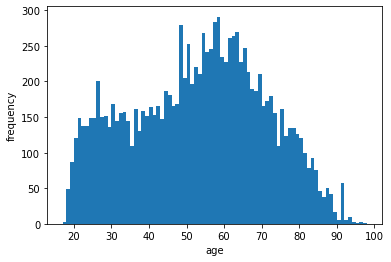

In [74]:
# Because it's a subtraction operation. Look at the age distribution. If there's a negative number, there's a problem.
age_counts = subjectAndcharttime7['age'].value_counts()
print(f"The minimum age is {min(age_counts.index.tolist())}, the maximum age is {max(age_counts.index.tolist())}.")
plt.hist(subjectAndcharttime7['age'], bins=len(age_counts))
plt.xlabel('age')
plt.ylabel('frequency')
plt.show()

In [75]:
# add label
microbes1 = pd.read_csv('./mimic-iv-2.2/hosp/microbes1.csv')
microbes1

,org_name,En,Ch,BM
0,33889,NaN,楠,0
1,392,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",葡萄球菌，凝固酶阴性,1
2,125,STAPHYLOCOCCUS EPIDERMIDIS,表皮葡萄球菌,1
3,78,STAPH AUREUS COAG +,金黄色葡萄球菌,1
4,75,ESCHERICHIA COLI,大肠杆菌,1
5,45,CRYPTOCOCCUS NEOFORMANS,新型隐球菌,1
6,40,KLEBSIELLA PNEUMONIAE,肺炎克雷伯菌,1
7,37,STREPTOCOCCUS PNEUMONIAE,肺炎链球菌,1
8,22,CANCELLED,取消,0
9,19,ENTEROBACTER AEROGENES,产气肠杆菌,1


In [76]:
# Label the data whether it is BM
micro_events_csf1 = micro_events_csf.copy()
microbes1_indexed = microbes1.set_index("En")   # It's quick to do so.
micro_events_csf1["BM"] = micro_events_csf1["org_name"].map(microbes1_indexed["BM"])
micro_events_csf1

,microevent_id,subject_id,hadm_id,micro_specimen_id,order_provider_id,chartdate,charttime,spec_itemid,spec_type_desc,test_seq,storedate,storetime,test_itemid,test_name,org_itemid,org_name,isolate_num,quantity,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation,comments,culture,BM
398,399,10001217,24597018.0,3955691,NaN,2157-11-19 00:00:00,2157-11-19 02:37:00,70026,CSF;SPINAL FLUID,1,2157-11-19 00:00:00,2157-11-19 04:53:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0,0
399,400,10001217,24597018.0,3955691,NaN,2157-11-19 00:00:00,2157-11-19 02:37:00,70026,CSF;SPINAL FLUID,2,2157-11-22 00:00:00,2157-11-22 11:50:00,90268,FLUID CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.,0,0
1017,1018,10002557,NaN,3350281,NaN,2147-03-26 00:00:00,2147-03-26 21:05:00,70026,CSF;SPINAL FLUID,1,2147-03-27 00:00:00,2147-03-27 00:48:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0,0
1018,1019,10002557,NaN,3350281,NaN,2147-03-26 00:00:00,2147-03-26 21:05:00,70026,CSF;SPINAL FLUID,2,2147-03-30 00:00:00,2147-03-30 11:00:00,90268,FLUID CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.,0,0
1060,1061,10002559,NaN,3401726,NaN,2179-06-05 00:00:00,2179-06-05 01:17:00,70026,CSF;SPINAL FLUID,1,2179-06-05 00:00:00,2179-06-05 04:15:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228631,3228632,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,1,2119-07-07 00:00:00,2119-07-07 18:58:00,90270,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO POLYMORPHONUCLEAR LEUKOCYTES SEEN. NO MICR...,0,0
3228632,3228633,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,2,2119-07-10 00:00:00,2119-07-10 11:45:00,90268,FLUID CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO GROWTH.,0,0
3228633,3228634,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,3,NaN,NaN,90240,ACID FAST CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The sensitivity of an AFB smear on CSF is very...,0,0
3228634,3228635,19999784,NaN,2599783,P86PTJ,2119-07-07 00:00:00,NaN,70026,CSF;SPINAL FLUID,4,2119-07-28 00:00:00,2119-07-28 15:37:00,90269,FUNGAL CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO FUNGUS ISOLATED.,0,0


In [77]:
micro_events_csf2 = micro_events_csf1.copy()
micro_events_csf2['chartdate'] = micro_events_csf2['chartdate'].str[:10]
micro_events_csf2 = micro_events_csf2.groupby(['subject_id','chartdate'])['BM'].max().reset_index()
micro_events_csf2

,subject_id,chartdate,BM
0,10001217,2157-11-19,0
1,10002557,2147-03-26,0
2,10002559,2179-06-05,0
3,10003019,2174-09-18,0
4,10005808,2119-01-02,0
...,...,...,...
11886,19994772,2181-04-18,0
11887,19995080,2147-07-13,0
11888,19997843,2120-11-18,0
11889,19999784,2119-06-22,0


In [78]:
# Add labels. Use the merge() function to add the BM columns from micro_events_csf2 to subjectAndcharttime7. Note that the on parameter specifies the columns to be used for merging, and how=‘left’ indicates a left join, i.e., all rows in subjectAndcharttime7 are retained, and a NaN value is added for rows for which no match can be found.
subjectAndcharttime8 = subjectAndcharttime7.copy()
subjectAndcharttime8 = subjectAndcharttime8.merge(micro_events_csf2[['subject_id', 'chartdate', 'BM']], on=['subject_id', 'chartdate'], how='left')
subjectAndcharttime8 = subjectAndcharttime8.drop(['birthyear', 'chartdate_int'],axis=1)
subjectAndcharttime8

,subject_id,chartdate,Blood Gas~Blood~Alveolar-arterial Gradient~50801~mm Hg,Blood Gas~Blood~Base Excess~50802~mEq/L,"Blood Gas~Blood~Calculated Bicarbonate, Whole Blood~50803~mEq/L",Blood Gas~Blood~Calculated Total CO2~50804~mEq/L,Blood Gas~Blood~Carboxyhemoglobin~50805~%,"Blood Gas~Blood~Chloride, Whole Blood~50806~mEq/L",Blood Gas~Blood~Free Calcium~50808~mmol/L,Blood Gas~Blood~Glucose~50809~mg/dL,"Blood Gas~Blood~Hematocrit, Calculated~50810~%",Blood Gas~Blood~Hemoglobin~50811~g/dL,Blood Gas~Blood~Intubated~50812~,Blood Gas~Blood~Lactate~50813~mmol/L,Blood Gas~Blood~Methemoglobin~50814~%,Blood Gas~Blood~O2 Flow~50815~L/min,Blood Gas~Blood~Oxygen~50816~%,Blood Gas~Blood~Oxygen Saturation~50817~%,Blood Gas~Blood~pCO2~50818~mm Hg,Blood Gas~Blood~PEEP~50819~,Blood Gas~Blood~pH~50820~units,Blood Gas~Blood~pO2~50821~mm Hg,"Blood Gas~Blood~Potassium, Whole Blood~50822~mEq/L",Blood Gas~Blood~Required O2~50823~,"Blood Gas~Blood~Sodium, Whole Blood~50824~mEq/L",Blood Gas~Blood~Temperature~50825~,Blood Gas~Blood~Tidal Volume~50826~,Blood Gas~Blood~Ventilation Rate~50827~,Blood Gas~Blood~Ventilator~50828~,Chemistry~Blood~% Hemoglobin A1c~50852~%,Chemistry~Blood~25-OH Vitamin D~50853~ng/mL,Chemistry~Blood~Absolute A1c~50854~,Chemistry~Blood~Absolute Hemoglobin~50855~,Chemistry~Blood~Acetaminophen~50856~ug/mL,Chemistry~Blood~Acetone~50857~,Chemistry~Blood~Acid Phosphatase~50858~,"Chemistry~Blood~Acid Phosphatase, Non-Prostatic~50859~","Chemistry~Blood~AFP, Maternal Screen~50860~",Chemistry~Blood~Alanine Aminotransferase (ALT)~50861~IU/L,Chemistry~Blood~Albumin~50862~g/dL,Chemistry~Blood~Alkaline Phosphatase~50863~IU/L,Chemistry~Blood~Alpha-Fetoprotein~50864~ng/mL,Chemistry~Blood~Amikacin~50865~ug/mL,Chemistry~Blood~Ammonia~50866~umol/L,Chemistry~Blood~Amylase~50867~IU/L,Chemistry~Blood~Anion Gap~50868~mEq/L,Chemistry~Blood~Anti-DGP (IgA/IgG)~50869~units,"Chemistry~Blood~Anti-Gliadin Antibody, IgA~50870~units",Chemistry~Blood~Anti-Mitochondrial Antibody~50871~,Chemistry~Blood~Anti-Neutrophil Cytoplasmic Antibody~50872~,...,Hematology~Blood~Factor XI~52851~,Hematology~Blood~Factor XII~52853~,Hematology~Blood~Factor XIII~52855~,Hematology~Blood~Fibrin Degradation Products~52858~,Hematology~Blood~Lupus Anticoagulant~52889~,Hematology~Blood~PT~52921~,Hematology~Blood~PTT~52923~,Hematology~Blood~Reptilase Time~52929~,"Hematology~Blood~Reticulocyte Count, Manual~52934~",Hematology~Blood~Thrombin~52948~,Chemistry~Blood~Alanine Aminotransferase~53084~,Chemistry~Blood~Albumin~53085~,Chemistry~Blood~Alkaline Phosphatase~53086~,Chemistry~Blood~Amylase~53087~,Chemistry~Blood~Asparate Aminotransferase~53088~,"Chemistry~Blood~Bilirubin, Total~53089~",Chemistry~Blood~Gamma Glutamyltranferase~53093~,Chemistry~Blood~HBV VL CT~53094~,Chemistry~Blood~Lyme VsIE/PepC10 Antibody~53095~,"Chemistry~Blood~Protein, Total~53096~",Chemistry~Blood~11-Deoxycorticosterone~53128~,Chemistry~Blood~3t~53129~,Chemistry~Blood~4t~53130~,Chemistry~Blood~5' Nucleotidase~53131~,Chemistry~Blood~Absolute Lymphocyte Count~53132~,Chemistry~Blood~Absolute Neutrophil~53133~,Chemistry~Blood~Absolute Other WBC~53134~,"Chemistry~Blood~Acid Phosphatase, Prostatic Fraction~53135~",Chemistry~Blood~Adrenocorticotrophic Hormone~53136~,Chemistry~Blood~Afp Mom~53137~,Chemistry~Blood~(Albumin)~53138~,Chemistry~Blood~Aldosterone~53139~,Chemistry~Blood~Aldosterone~53140~,Chemistry~Blood~Alpha-1~53141~,Chemistry~Blood~Alpha-1-antitrypsin~53142~,Chemistry~Blood~Alpha-2~53143~,Chemistry~Blood~ANCA Titer~53144~,Chemistry~Blood~Anti-GBM Antibody~53145~,Chemistry~Blood~Anti Hav~53146~,Chemistry~Blood~Anti Hbc~53147~,Chemistry~Blood~Anti Hbe~53148~,Chemistry~Blood~Anti-hbs~53149~,Chemistry~Blood~Anti Hbs~53150~,Chemistry~Blood~Anti-la~53151~,Chemistry~Blood~HIV FINAL~53152~,Chemistry~Blood~HIV Screen~53153~,Chemistry~Blood~Lactate~53154~mmol/L,gender,age,BM
0,10001217,2157-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [79]:
subjectAndcharttime8.BM.value_counts()

0    11582
1      277
Name: BM, dtype: int64

In [80]:
# Pick out duplicates and put duplicates in front of the data
# Create a boolean mask that flags rows with duplicate subject_id's
duplicates_mask = subjectAndcharttime8.duplicated(subset='subject_id', keep=False)

# Use boolean mask to split rows with duplicate subject_id into two dataframes
duplicates_df = subjectAndcharttime8[duplicates_mask]
unique_df = subjectAndcharttime8[~duplicates_mask]

# Concatenate two dataframes to put the row with the duplicate subject_id first
result = pd.concat([duplicates_df, unique_df], axis=0)
print(f"重复subject_id的个数为{duplicates_df.shape[0]}，唯一subject_id的个数为{unique_df.shape[0]}。")
result

重复subject_id的个数为4877，唯一subject_id的个数为6982。


,subject_id,chartdate,Blood Gas~Blood~Alveolar-arterial Gradient~50801~mm Hg,Blood Gas~Blood~Base Excess~50802~mEq/L,"Blood Gas~Blood~Calculated Bicarbonate, Whole Blood~50803~mEq/L",Blood Gas~Blood~Calculated Total CO2~50804~mEq/L,Blood Gas~Blood~Carboxyhemoglobin~50805~%,"Blood Gas~Blood~Chloride, Whole Blood~50806~mEq/L",Blood Gas~Blood~Free Calcium~50808~mmol/L,Blood Gas~Blood~Glucose~50809~mg/dL,"Blood Gas~Blood~Hematocrit, Calculated~50810~%",Blood Gas~Blood~Hemoglobin~50811~g/dL,Blood Gas~Blood~Intubated~50812~,Blood Gas~Blood~Lactate~50813~mmol/L,Blood Gas~Blood~Methemoglobin~50814~%,Blood Gas~Blood~O2 Flow~50815~L/min,Blood Gas~Blood~Oxygen~50816~%,Blood Gas~Blood~Oxygen Saturation~50817~%,Blood Gas~Blood~pCO2~50818~mm Hg,Blood Gas~Blood~PEEP~50819~,Blood Gas~Blood~pH~50820~units,Blood Gas~Blood~pO2~50821~mm Hg,"Blood Gas~Blood~Potassium, Whole Blood~50822~mEq/L",Blood Gas~Blood~Required O2~50823~,"Blood Gas~Blood~Sodium, Whole Blood~50824~mEq/L",Blood Gas~Blood~Temperature~50825~,Blood Gas~Blood~Tidal Volume~50826~,Blood Gas~Blood~Ventilation Rate~50827~,Blood Gas~Blood~Ventilator~50828~,Chemistry~Blood~% Hemoglobin A1c~50852~%,Chemistry~Blood~25-OH Vitamin D~50853~ng/mL,Chemistry~Blood~Absolute A1c~50854~,Chemistry~Blood~Absolute Hemoglobin~50855~,Chemistry~Blood~Acetaminophen~50856~ug/mL,Chemistry~Blood~Acetone~50857~,Chemistry~Blood~Acid Phosphatase~50858~,"Chemistry~Blood~Acid Phosphatase, Non-Prostatic~50859~","Chemistry~Blood~AFP, Maternal Screen~50860~",Chemistry~Blood~Alanine Aminotransferase (ALT)~50861~IU/L,Chemistry~Blood~Albumin~50862~g/dL,Chemistry~Blood~Alkaline Phosphatase~50863~IU/L,Chemistry~Blood~Alpha-Fetoprotein~50864~ng/mL,Chemistry~Blood~Amikacin~50865~ug/mL,Chemistry~Blood~Ammonia~50866~umol/L,Chemistry~Blood~Amylase~50867~IU/L,Chemistry~Blood~Anion Gap~50868~mEq/L,Chemistry~Blood~Anti-DGP (IgA/IgG)~50869~units,"Chemistry~Blood~Anti-Gliadin Antibody, IgA~50870~units",Chemistry~Blood~Anti-Mitochondrial Antibody~50871~,Chemistry~Blood~Anti-Neutrophil Cytoplasmic Antibody~50872~,...,Hematology~Blood~Factor XI~52851~,Hematology~Blood~Factor XII~52853~,Hematology~Blood~Factor XIII~52855~,Hematology~Blood~Fibrin Degradation Products~52858~,Hematology~Blood~Lupus Anticoagulant~52889~,Hematology~Blood~PT~52921~,Hematology~Blood~PTT~52923~,Hematology~Blood~Reptilase Time~52929~,"Hematology~Blood~Reticulocyte Count, Manual~52934~",Hematology~Blood~Thrombin~52948~,Chemistry~Blood~Alanine Aminotransferase~53084~,Chemistry~Blood~Albumin~53085~,Chemistry~Blood~Alkaline Phosphatase~53086~,Chemistry~Blood~Amylase~53087~,Chemistry~Blood~Asparate Aminotransferase~53088~,"Chemistry~Blood~Bilirubin, Total~53089~",Chemistry~Blood~Gamma Glutamyltranferase~53093~,Chemistry~Blood~HBV VL CT~53094~,Chemistry~Blood~Lyme VsIE/PepC10 Antibody~53095~,"Chemistry~Blood~Protein, Total~53096~",Chemistry~Blood~11-Deoxycorticosterone~53128~,Chemistry~Blood~3t~53129~,Chemistry~Blood~4t~53130~,Chemistry~Blood~5' Nucleotidase~53131~,Chemistry~Blood~Absolute Lymphocyte Count~53132~,Chemistry~Blood~Absolute Neutrophil~53133~,Chemistry~Blood~Absolute Other WBC~53134~,"Chemistry~Blood~Acid Phosphatase, Prostatic Fraction~53135~",Chemistry~Blood~Adrenocorticotrophic Hormone~53136~,Chemistry~Blood~Afp Mom~53137~,Chemistry~Blood~(Albumin)~53138~,Chemistry~Blood~Aldosterone~53139~,Chemistry~Blood~Aldosterone~53140~,Chemistry~Blood~Alpha-1~53141~,Chemistry~Blood~Alpha-1-antitrypsin~53142~,Chemistry~Blood~Alpha-2~53143~,Chemistry~Blood~ANCA Titer~53144~,Chemistry~Blood~Anti-GBM Antibody~53145~,Chemistry~Blood~Anti Hav~53146~,Chemistry~Blood~Anti Hbc~53147~,Chemistry~Blood~Anti Hbe~53148~,Chemistry~Blood~Anti-hbs~53149~,Chemistry~Blood~Anti Hbs~53150~,Chemistry~Blood~Anti-la~53151~,Chemistry~Blood~HIV FINAL~53152~,Chemistry~Blood~HIV Screen~53153~,Chemistry~Blood~Lactate~53154~mmol/L,gender,age,BM
19,10027602,2201-11-06,NaN,1.0,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,NaN,7.47,131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [81]:
# save
result.to_csv('mimic_filtered_baidu.csv',index=False)